# Compound Pendulum: taking into account rotations of the mass

[5.57247482 4.42461578]
45.0 -4.899092453787766 155.0 -45.0


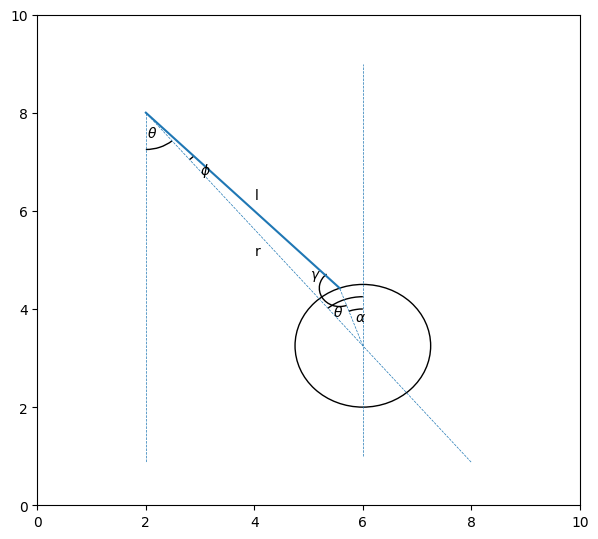

In [55]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import patches
import math
from IPython.display import HTML

fig = plt.figure()
fig.set_dpi(100)
fig.set_size_inches(7, 6.5)

r=1.25
center=np.array([6,3.25])
alphaDegrees=20
alpha=alphaDegrees*np.pi/180. #degrees
pivot=center+r*np.array([math.cos(np.pi/2+alpha),math.sin(np.pi/2+alpha)])
print(pivot)
ax = plt.axes(xlim=(0, 10), ylim=(0, 10))
ax.add_line(plt.Line2D((2, pivot[0]), (8, pivot[1]), lw=1.5))
ax.add_line(plt.Line2D((6,6),(1,9),lw=0.5,ls='dashed'))
ax.add_line(plt.Line2D((2,8),(8,8-4.75*1.5),ls='dashed',lw=0.5))
ax.add_line(plt.Line2D((2,2),(8,8-4.75*1.5),ls='dashed',lw=0.5))
ax.add_line(plt.Line2D((center[0],pivot[0]),(center[1],pivot[1]),ls='dashed',lw=0.5))
patch = plt.Circle(center, r,fill=False)
ax.add_patch(patch)
theta1=math.atan2(-4.75,4)*180/math.pi
theta2=math.atan2(-4,4)*180/math.pi
angleLabel=r'$\theta$'
ax.add_patch(patches.Arc((2,8),1.5,1.5,0,270,theta1))
ax.text(2.02,7.5,angleLabel)
ax.add_patch(patches.Arc((2,8),2.5,2.5,0,theta1,theta2))
ang2Label=r'$\phi$'
ax.text(3,6.75,ang2Label)
ax.add_patch(patches.Arc(center,1.5,1.5,0,90,90+alphaDegrees))
ax.text(center[0]-.15,center[1]+.5,r'$\alpha$')
ax.add_patch(patches.Arc(center,2,2,0,90,theta1-180))
ax.text(center[0]-.55,center[1]+.6,r'$\theta$')
phi=(theta1-theta2)
theta=-theta2
gamma=180-(phi-theta1-alphaDegrees)
print(theta,phi,gamma,theta2)
ax.add_patch(patches.Arc(pivot,0.75,0.75,0,90+theta+phi,270+alphaDegrees))
ax.text(pivot[0]-.55,pivot[1]+.2,r'$\gamma$')
ax.text(4,6.25,'l')
ax.text(4,5.1,'r')
plt.show()


# Angular Momentum
We add a variable $\alpha$ that gives the mass the freedom to rotate with respect to the string.  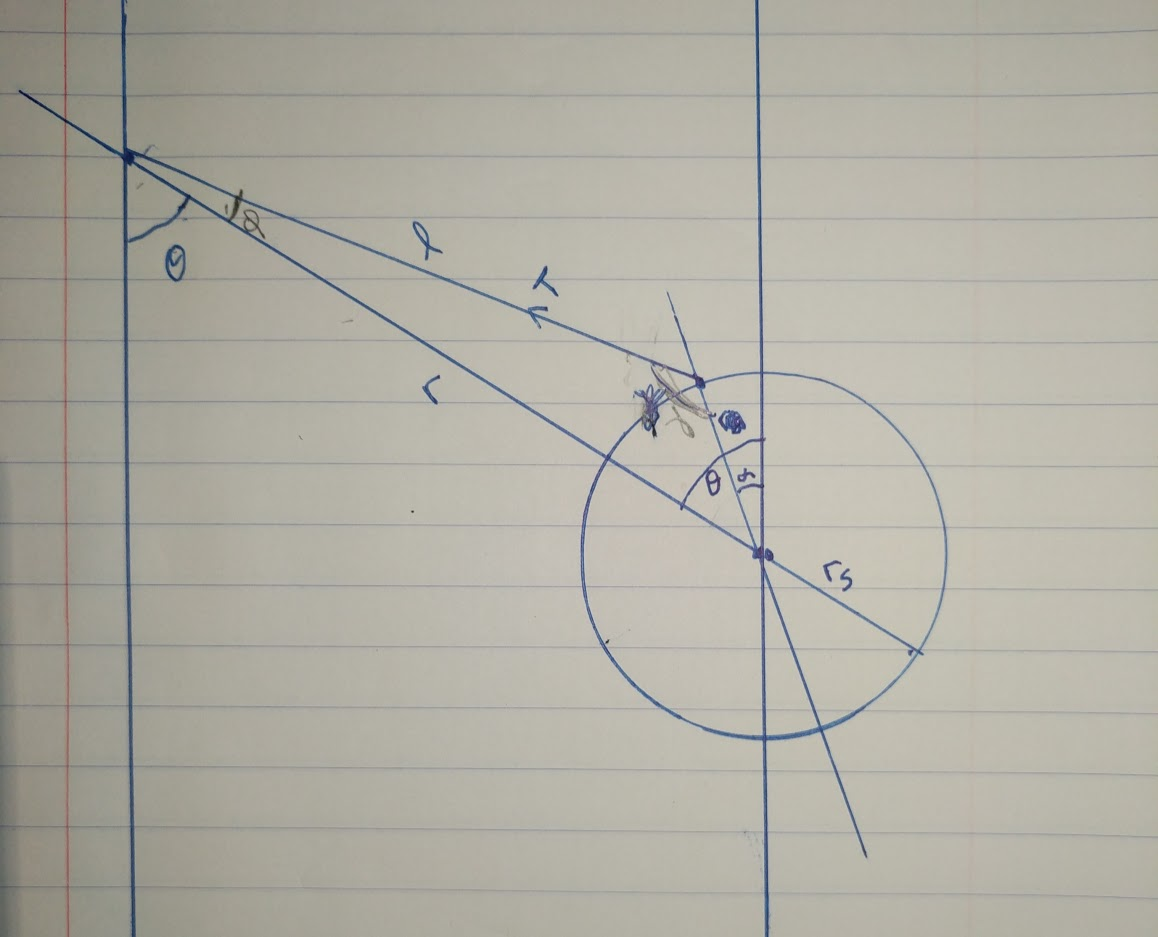

In spherical coordinates, ignoring $\phi$, we have 
\begin{equation}F_r=m\ddot{r}-mr\dot{\theta}^2=mg\cos{\theta}-T\cos\phi\end{equation}
\begin{equation}F_\theta=mr\ddot{\theta}+2m\dot{\theta}\dot{r}=-mg\sin{\theta}-T\sin\phi\end{equation}
\begin{equation}\tau=I\ddot{\alpha}\rightarrow\frac{2}{5}mr_s^2\ddot{\alpha}=r_sT\sin(\gamma)\end{equation}
Here $r_s$ refers to the radius of the sphere, and r to the position of the center of mass.

For the torque equation, we make use of the law of sines:
\begin{equation}\frac{l}{\sin(\theta-\alpha)}=\frac{r}{\sin\gamma}=\frac{r_s}{\sin\phi}\end{equation}

In addition we have the cosine law:
\begin{equation}l^2=r^2+r_s^2-2rr_s\cos(\theta-\alpha)\end{equation}
which we can differentiate to give
\begin{equation}r\dot{r}=r_s\dot{r}\cos(\theta-\alpha)-rr_s\sin(\theta-\alpha) (\dot{\theta}-\dot{\alpha})\end{equation}



and once more to give
\begin{equation}r\ddot{r}+\dot{r}^2=r_s\ddot{r}\cos(\theta-\alpha)-2r_s\dot{r}\sin(\theta-\alpha)(\dot{\theta}-\dot{\alpha})-rr_s(\ddot{\theta}-\ddot{\alpha})\sin(\theta-\alpha)\end{equation}

Our vector is now $y=(\theta,\dot{\theta}=\omega,\alpha,\dot{\alpha}=\beta)$; and our function needs to calculate $dy/dt=(\omega,\ddot{\theta}, \beta,\ddot{\alpha})$.  We have four equations of motion, and four unknowns: $\ddot{\theta},\ddot{\alpha},\ddot{r},T$.  

Our function starts by solving the linear set of equations in terms of known quantities, and then we can return the derivative.  Rewriting the set of equations in terms of matrix multiplication, we have:

\begin{equation}\left(\begin{array}{cccc}
0&0&m&\cos\phi\\
mr&0&0&\sin\phi\\
0&1&0&-\frac{r_sr}{lI}\sin(\theta-\alpha)\\
rr_s\sin(\theta-\alpha)&-rr_s\sin(\theta-\alpha)&r-r_s\cos(\theta-\alpha)&0
\end{array}\right)
\left(\begin{array}{c}
\ddot{\theta}\\
\ddot{\alpha}\\
\ddot{r}\\
T
\end{array}\right)=
\left(\begin{array}{c}
mg\cos\theta+mr\dot{\theta}^2\\
-mg\sin\theta-2m\dot{r}\dot{\theta}\\
0\\
-\dot{r}^2-2r_s\dot{r}(\dot{\theta}-\dot{\alpha})\sin(\theta-\alpha)
\end{array}\right)\end{equation}

We will invert these numerically.  

In [58]:
import pendulumParameters as p

Total Mass  0.02441547495810836
lcm  0.6311902802180227  l  0.639695
I, IMass, IString: 0.009813975740162914 0.009730557367544595 8.34183726183206e-05


In [59]:
def CompoundPendulum(y,t):
    theta,omega,alpha,beta=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    
    A=np.array([[0,0,mass,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    dydt=np.array([omega,thetaddot,beta, alphaddot])
    return dydt
    

# Validation
This was a little complicated.  But, even for simple functions,  we should *always* look to validate the function before we go on- if the function isn't describing the pendulum we are integrating something that is not our physical system. 

How do we do that?  We will, again, check the energy.  But we will also "plug our variables back into our original equations to make sure the solution is right".  And we can double check the numerical integrals.  

Our implementation will be to add variables to our integration function.  We will make our function return 
\begin{equation}
dy/dt=(\dot{\theta},\dot{\omega},\dot{\alpha},\dot{\beta},E_t,F_r-ma_r, F_\theta-ma_\theta, r^2-(l^2+r_s^2+2lr_s\cos(\pi-\phi-\theta+\alpha))
\end{equation}

Note the change in angle.  This just checks the geometry.  

The last three elements should always be zero.  $E_t,$ the total energy is a constant, and so we expect that \begin{equation}dy[4]/dt=E_t\rightarrow y[4]=tE_t\end{equation} If we plot $y[4]/t-E_t(0)$ we will also have a flat line.



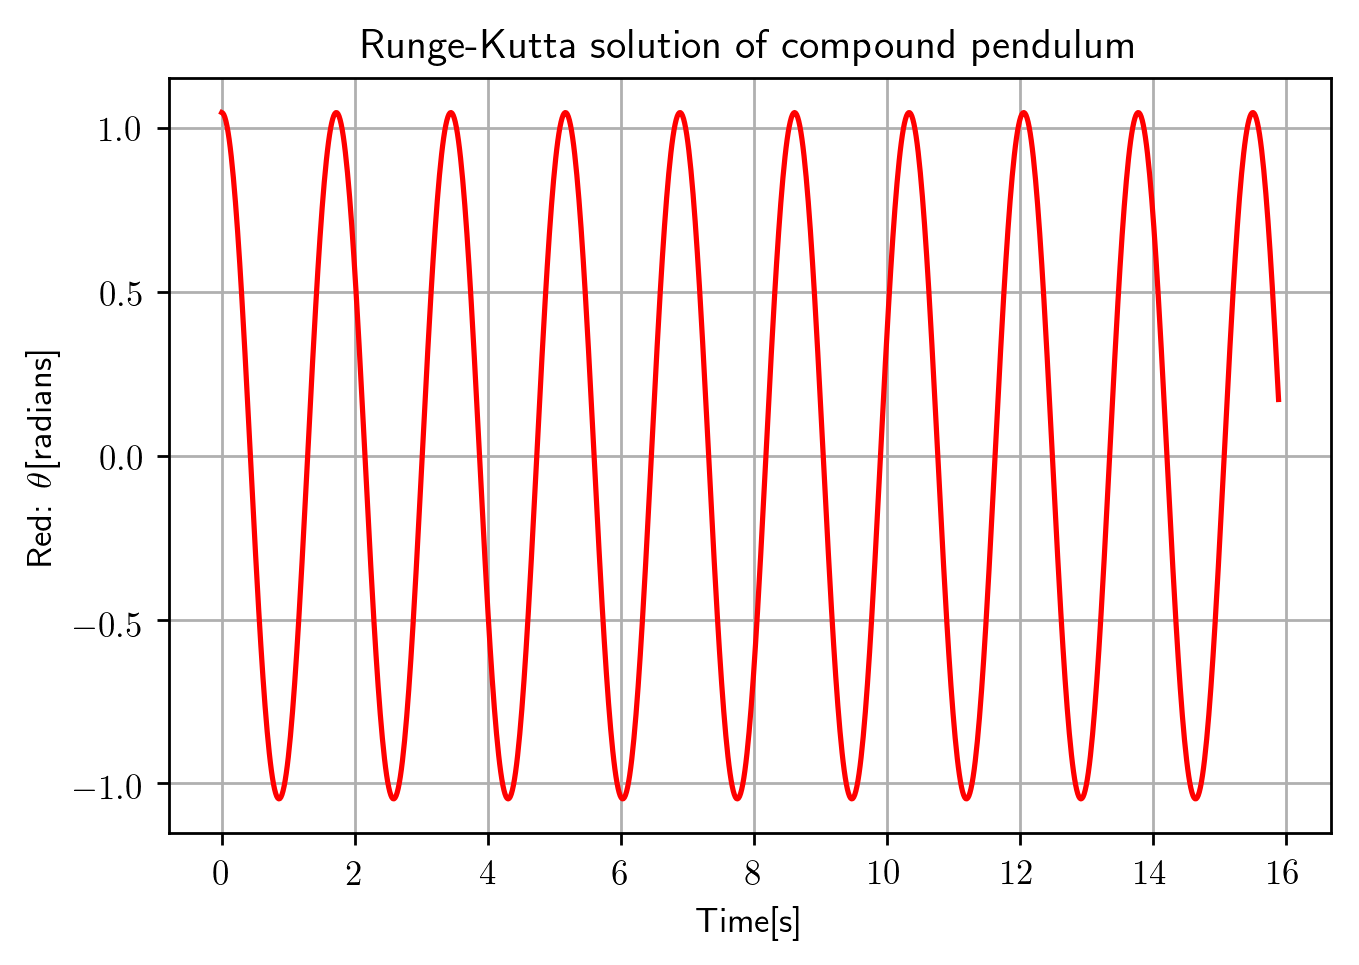

In [60]:
#Unvalidated code- this contains a few bugs that are revealed through our validation process.  
#The right code appears later in the notebook

import numpy as np
from scipy.integrate import odeint

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
mpl.rc('text',usetex=True)

def CompoundPendulum(y,t):
    theta,omega,alpha,beta,E,in1,in2,in3=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    
    A=np.array([[0,0,mass*r,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    E=1/2*mass*r**2*omega**2-mass*g*r*np.cos(theta)+1/2*I*alpha**2
    delR=mass*rddot-mass*r*omega**2-mass*g*np.cos(theta)+T*cosphi
    delTheta=mass*r*thetaddot+2*mass*rdot*omega+mass*g*np.sin(theta)+T*cosphi
    rcheck=r**2-(radius**2+l**2+2*radius*l*np.cos(np.pi-np.arcsin(sinphi)-theta+alpha))

    dydt=np.array([omega,thetaddot,beta, alphaddot,E,delR,delTheta,rcheck])
    return dydt    

#and now we set up some constants (measured quantities)

g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
mass=p.mMass #0.029 #kg  mass of pendulum bob
radius=p.dMass/2 #.00949 #m radius of pendulum bob
l=p.stringLength #length of pendulum wire, meters (subtract off radius now)
I=2/5*mass*radius**2 #moment of inertia of sphere

omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3

#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 10*T, 1001)

E0=-mass*g*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0,E0,0,0,0])
relativeTolerance=np.array([2e-8,2e-8,2e-8,2e-8,1,1,1,1])
    
solution = odeint(CompoundPendulum, y0, t,rtol=relativeTolerance, atol=relativeTolerance)

plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 0], 'r', label='rk theta(t)')
plt.ylabel(r'Red: $\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     



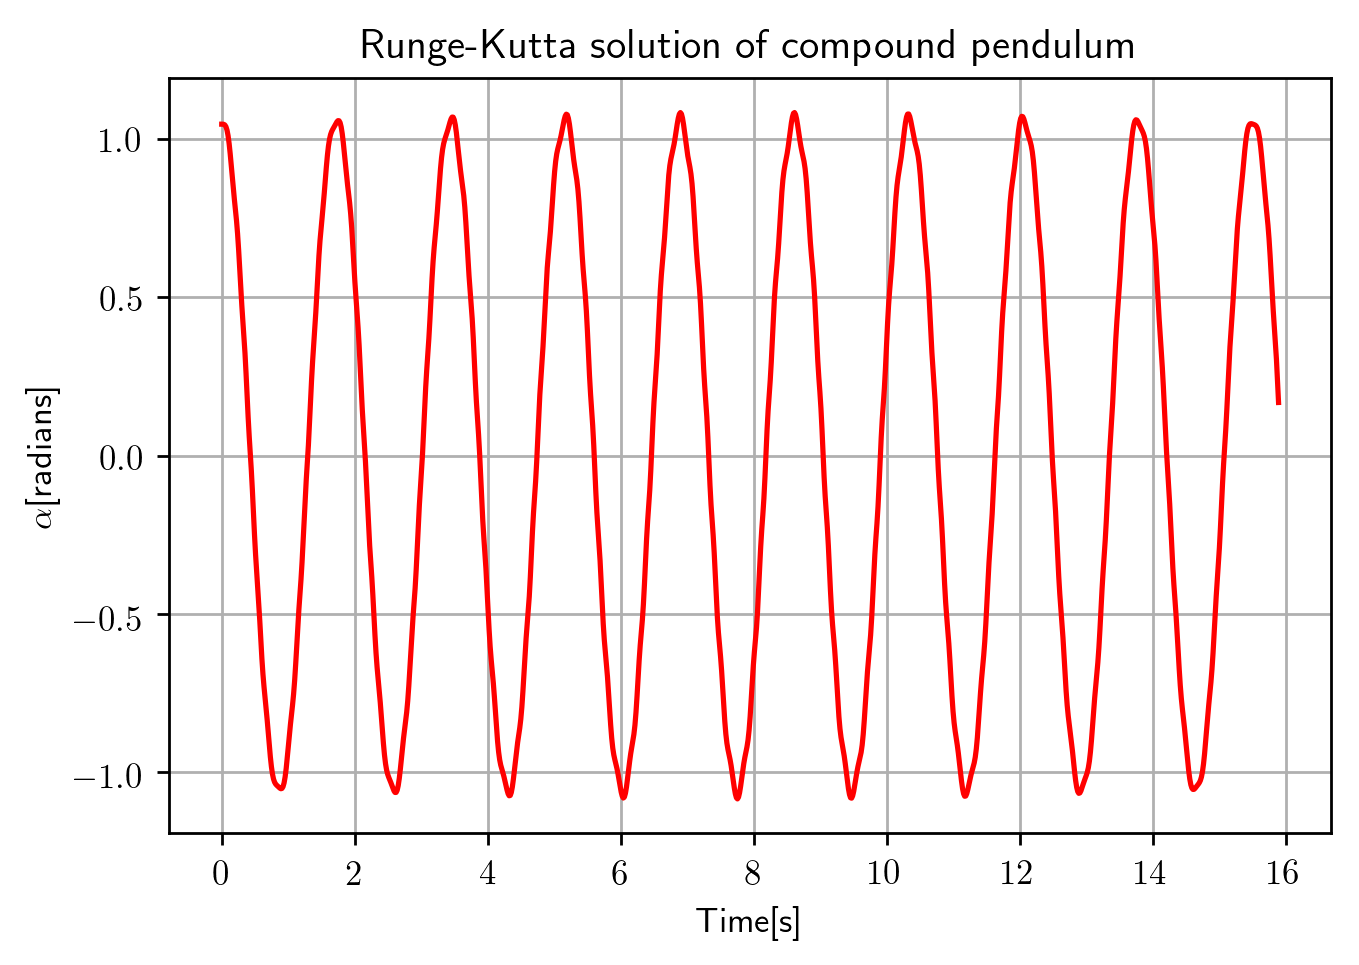

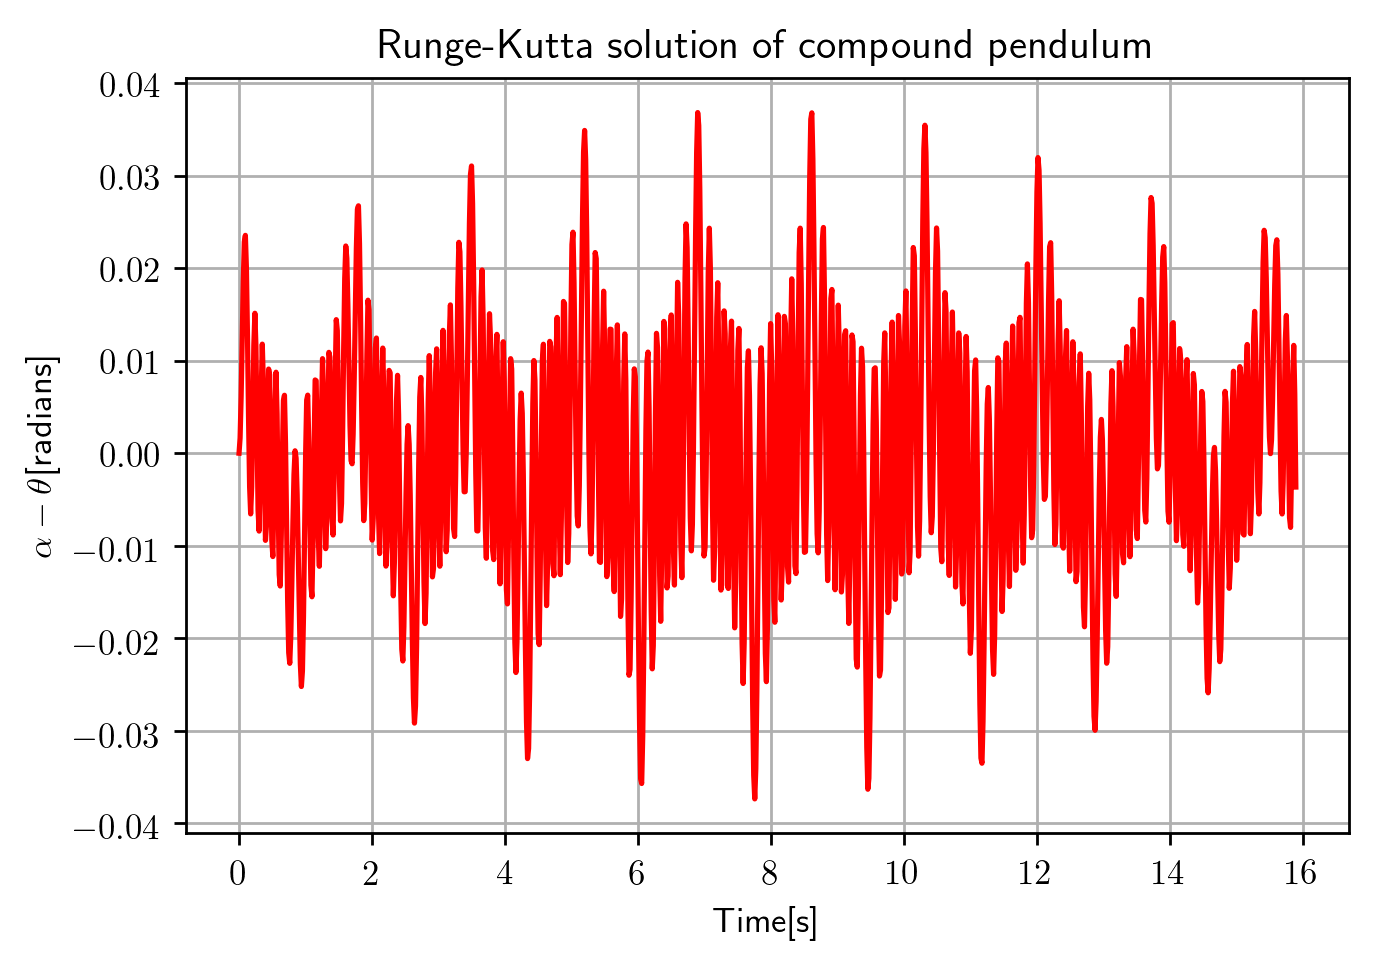

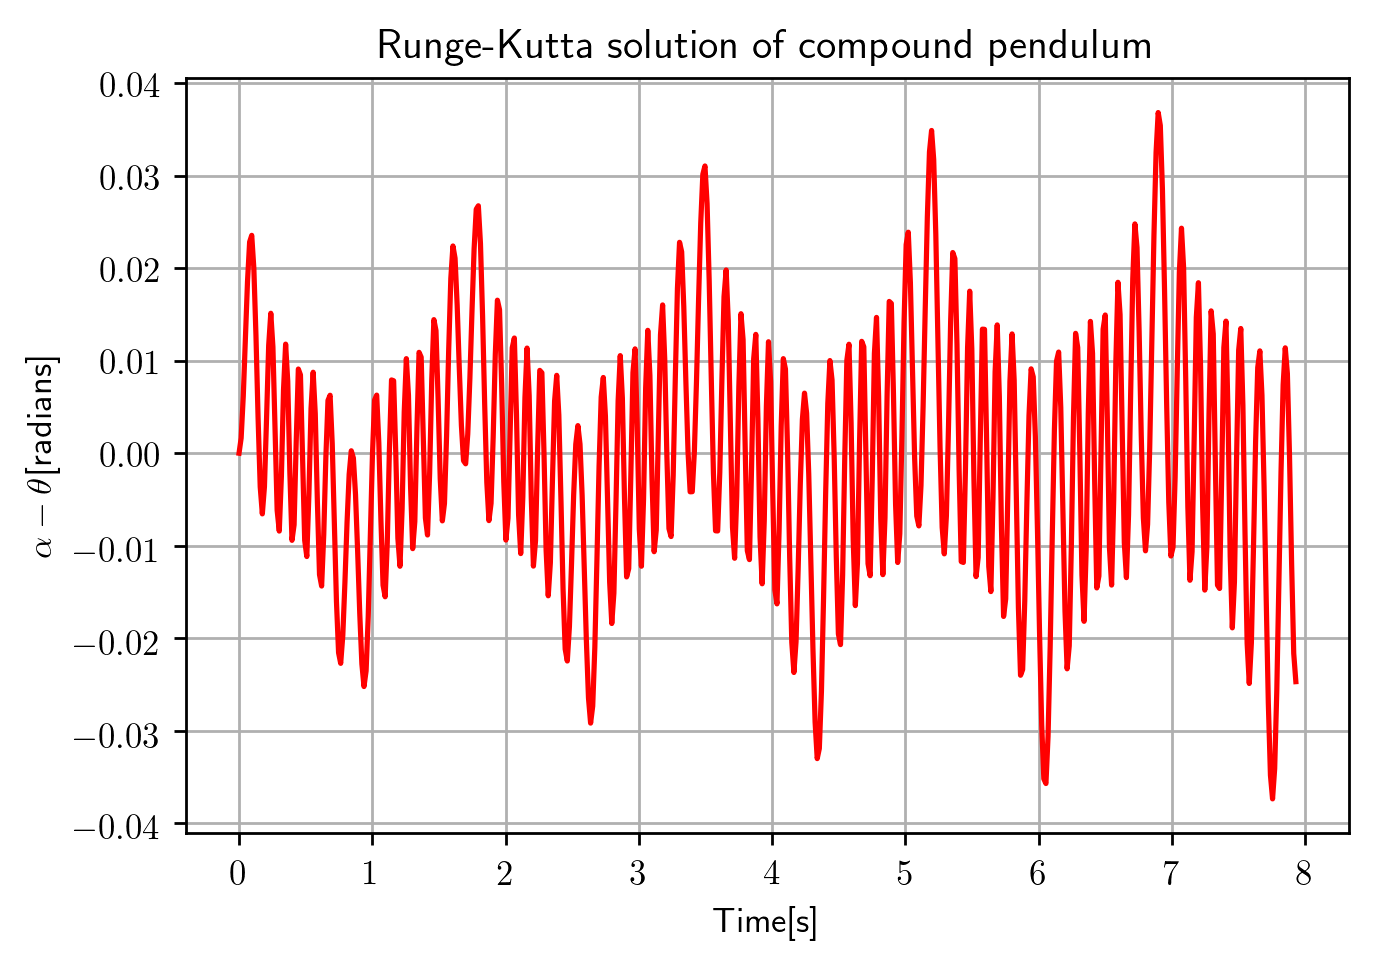

In [61]:
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 2], 'r', label='rk alpha(t)')
plt.ylabel(r'$\alpha$[radians]')
plt.xlabel('Time[s]')
plt.grid()  
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 2]-solution[:,0], 'r', label='rk alpha(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[0:500], solution[0:500, 2]-solution[0:500,0], 'r', label='rk alpha(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     



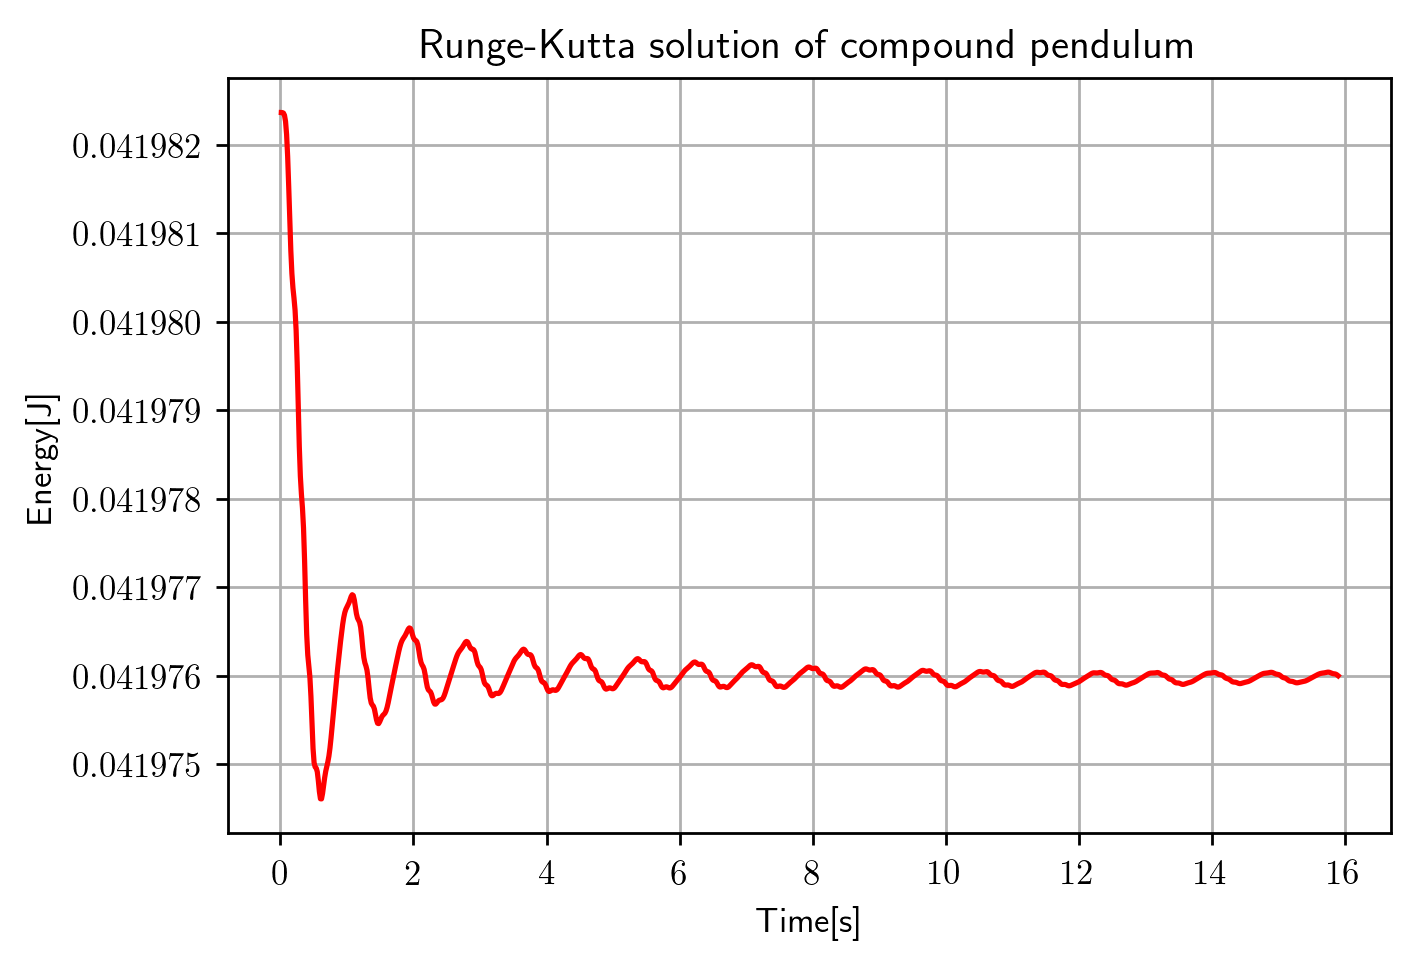

In [62]:
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[1:], (solution[1:,4]-solution[0,4])/t[1:]-solution[0,4], 'r', label='Energy')
plt.ylabel('Energy[J]')
plt.xlabel('Time[s]')
plt.grid()             

This doesn't look right!  Why the feature at time 0?  And it seems unreasonable that there still is a zero offset and that the size is 1e-5.  This forced me to go back and look at the code- and I found two bugs- one in E0, and one in the calculation of the energy within the function.

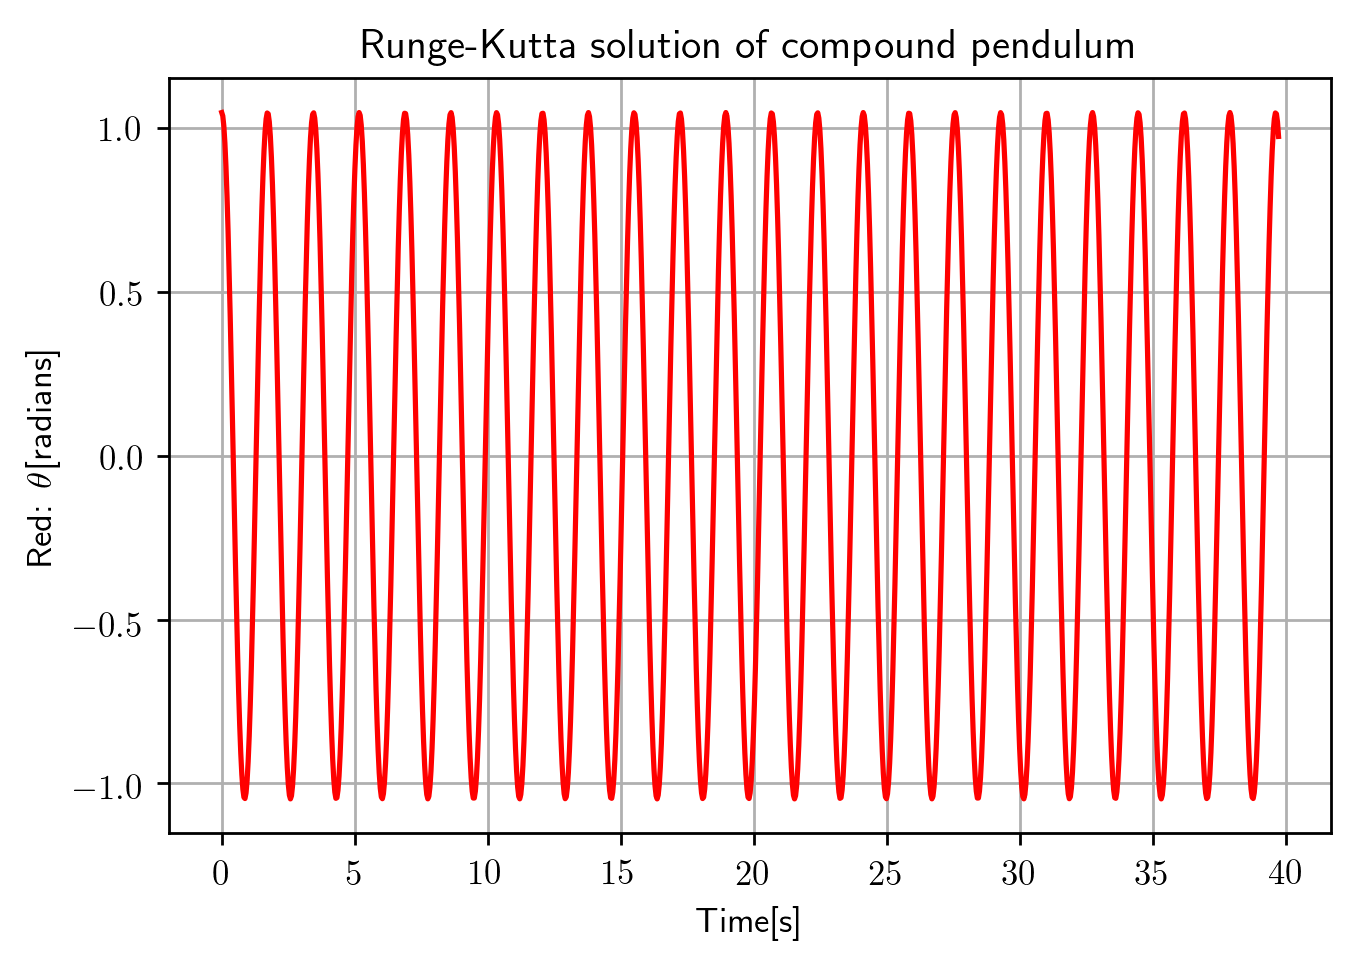

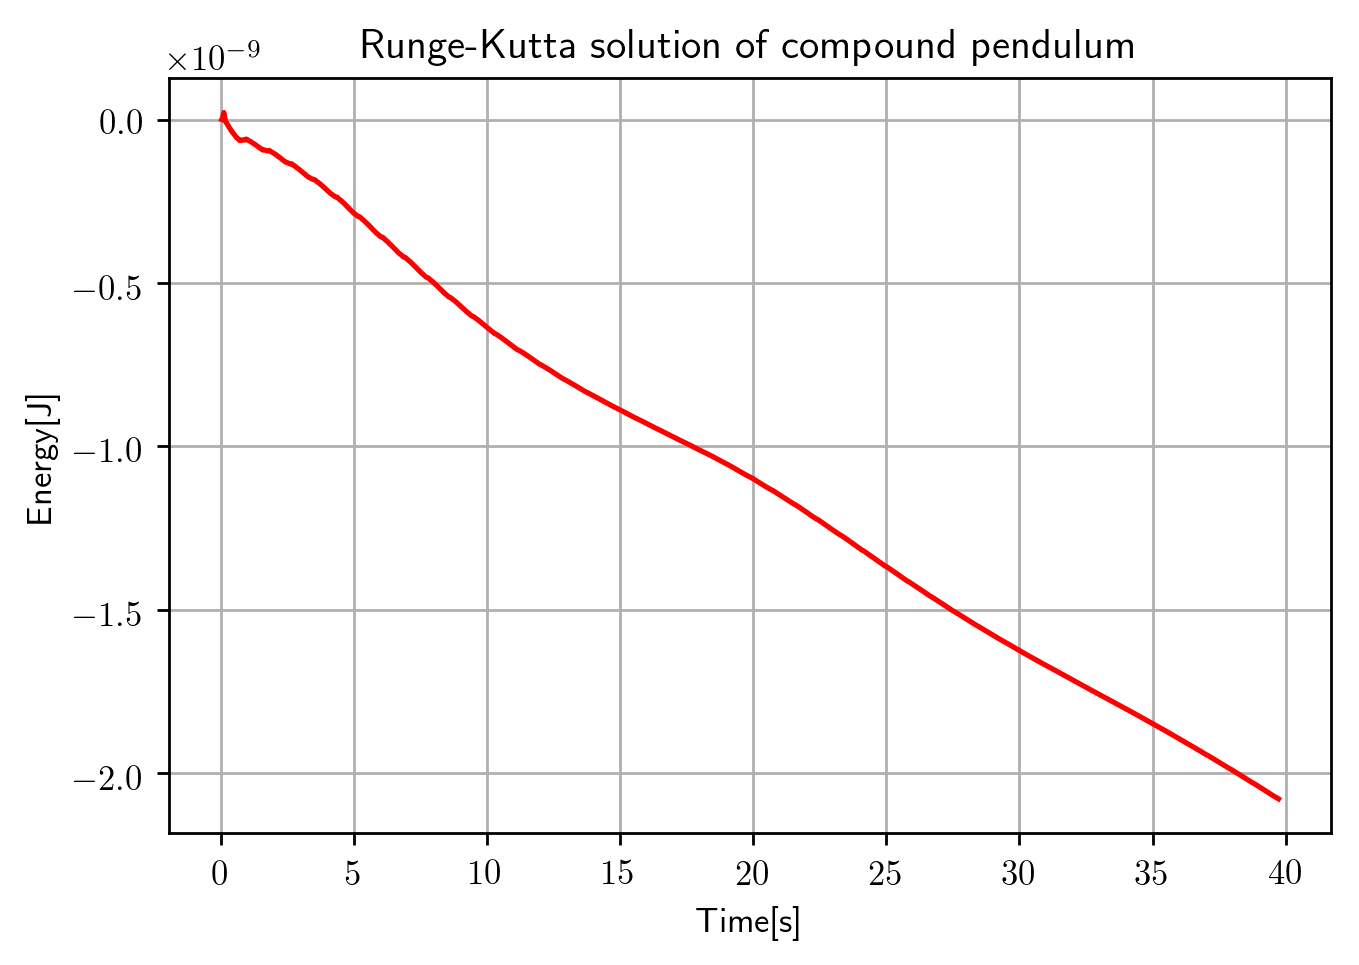

In [63]:
#partially validated code- still contains a bug

def CompoundPendulum(y,t):
    theta,omega,alpha,beta,E,in1,in2,in3=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    
    A=np.array([[0,0,mass*r,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    #note beta in equation below instead of alpha!
    E=1/2*mass*r**2*omega**2-mass*g*r*np.cos(theta)+1/2*I*beta**2
    delR=mass*rddot-mass*r*omega**2-mass*g*np.cos(theta)+T*cosphi
    delTheta=mass*r*thetaddot+2*mass*rdot*omega+mass*g*np.sin(theta)+T*sinphi
    rcheck=r**2-(radius**2+l**2+2*radius*l*np.cos(np.arcsin(sinphi)+theta-alpha))

    dydt=np.array([omega,thetaddot,beta, alphaddot,E,delR,delTheta,rcheck])
    return dydt    

#and now we set up some constants (measured quantities)

g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
mass=p.mMass #0.029 #kg  mass of pendulum bob
radius=p.dMass/2 #.00949 #m radius of pendulum bob
l=p.stringLength #length of pendulum wire, meters (subtract off radius now)
I=2/5*mass*radius**2 #moment of inertia of sphere

omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3

#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 25*T, 1001)
#note fix in equation below
E0=-mass*g*(l+radius)*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0,E0,0,0,0])
relativeTolerance=np.array([2e-8,2e-8,2e-8,2e-8,1,1,1,1])
    
solution = odeint(CompoundPendulum, y0, t,rtol=relativeTolerance, atol=relativeTolerance)

plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 0], 'r', label='rk theta(t)')
plt.ylabel(r'Red: $\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     

plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[1:], (solution[1:,4]-solution[0,4])/t[1:]-solution[0,4], 'r', label='Energy')
plt.ylabel('Energy[J]')
plt.xlabel('Time[s]')
plt.grid()             

This is obviously much better.  

Check the other three validations

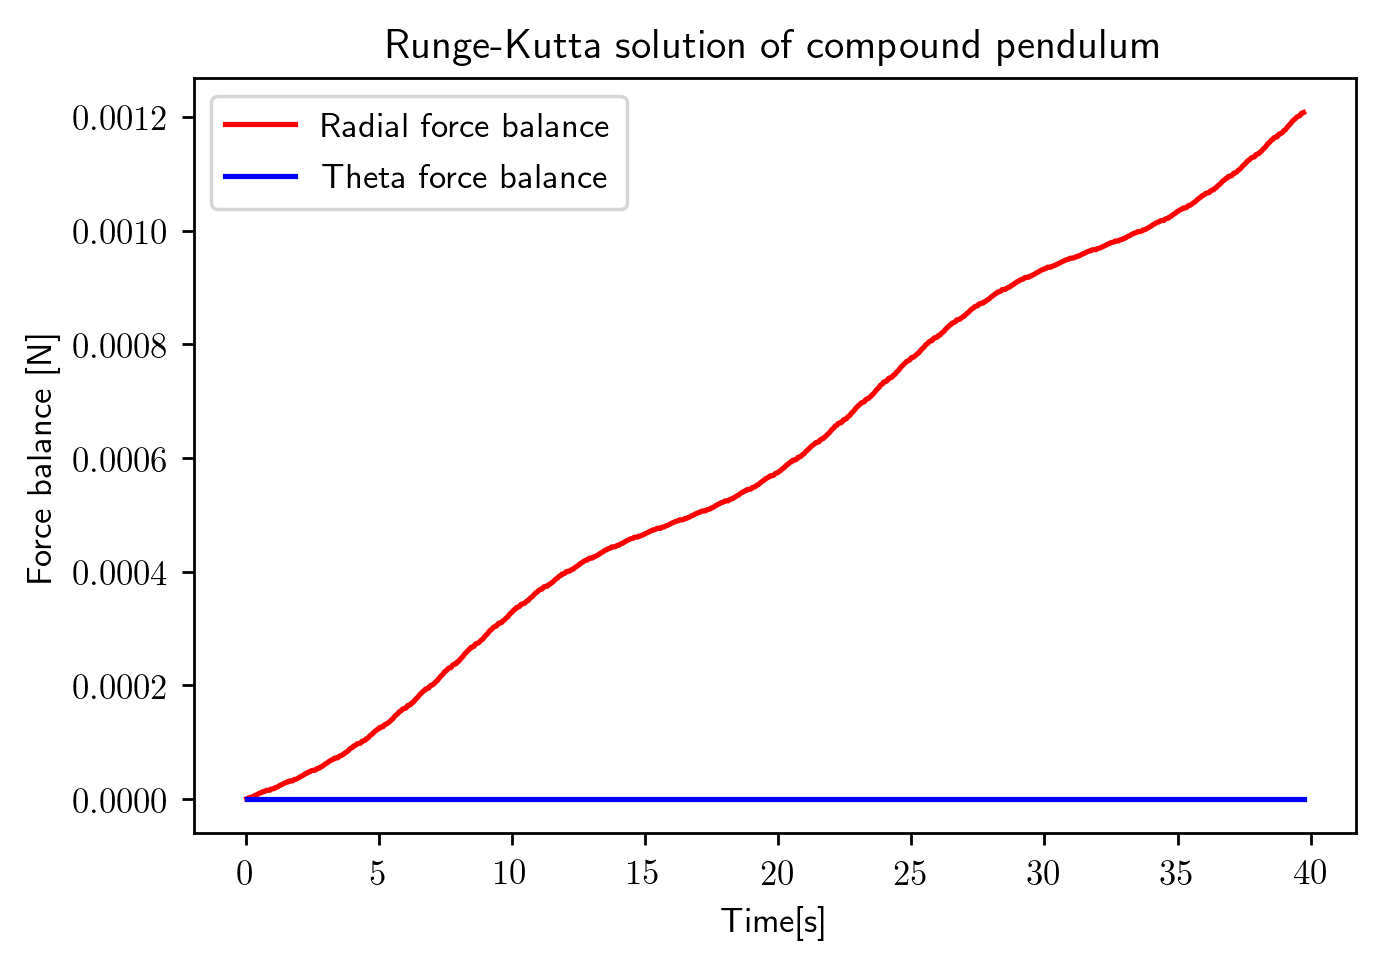

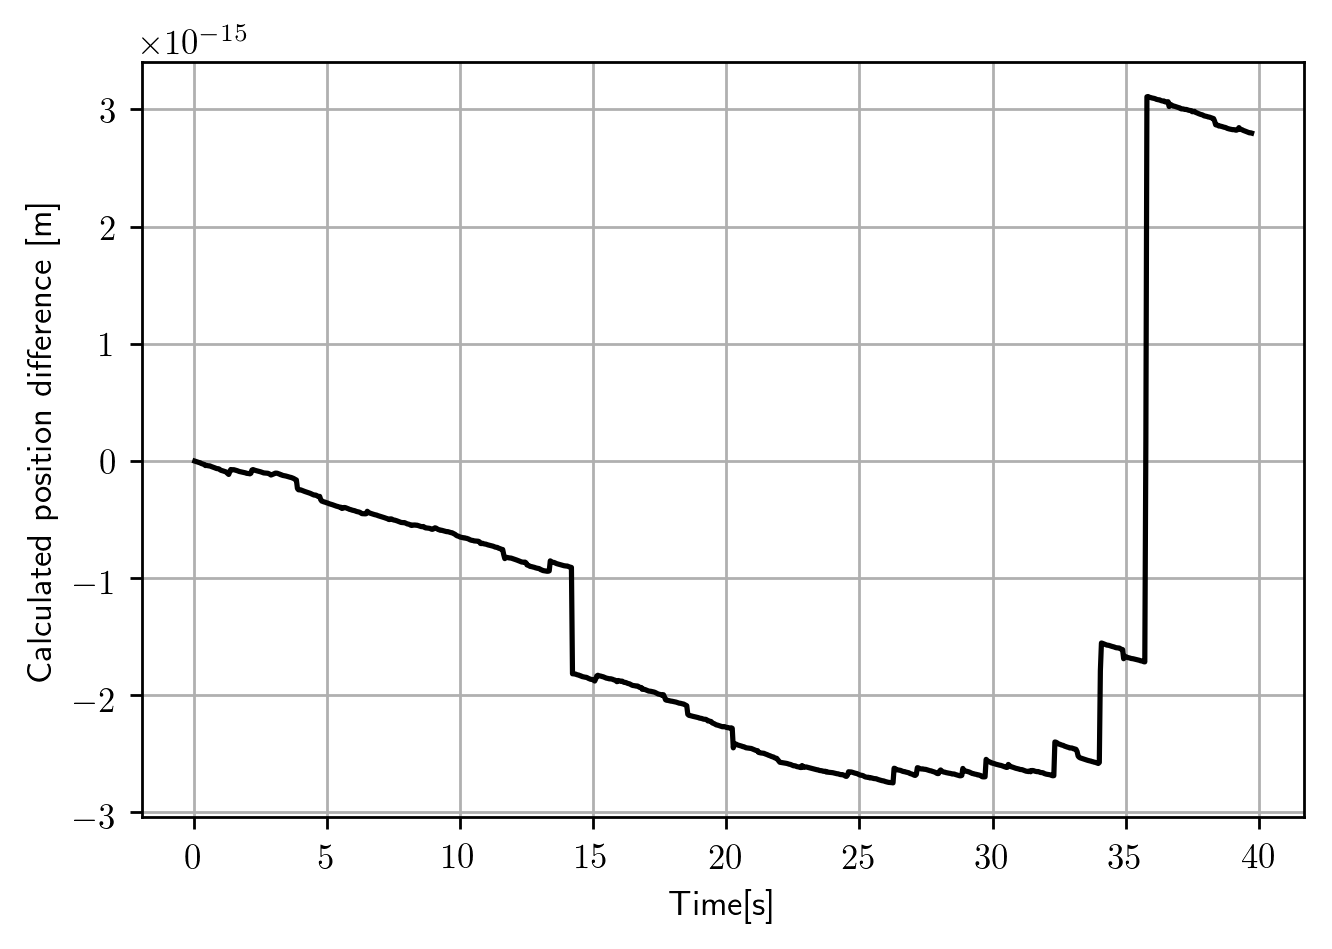

In [64]:
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[1:],solution[1:,5], 'r', label='Radial force balance')
plt.ylabel('Force balance [N]')
plt.xlabel('Time[s]')
plt.plot(t[1:],solution[1:,6], 'b', label='Theta force balance')
plt.legend()        

plt.figure()         
plt.plot(t[1:],solution[1:,7], 'k', label='Cosine law check')
plt.ylabel('Calculated position difference [m]')
plt.xlabel('Time[s]')
plt.grid()             

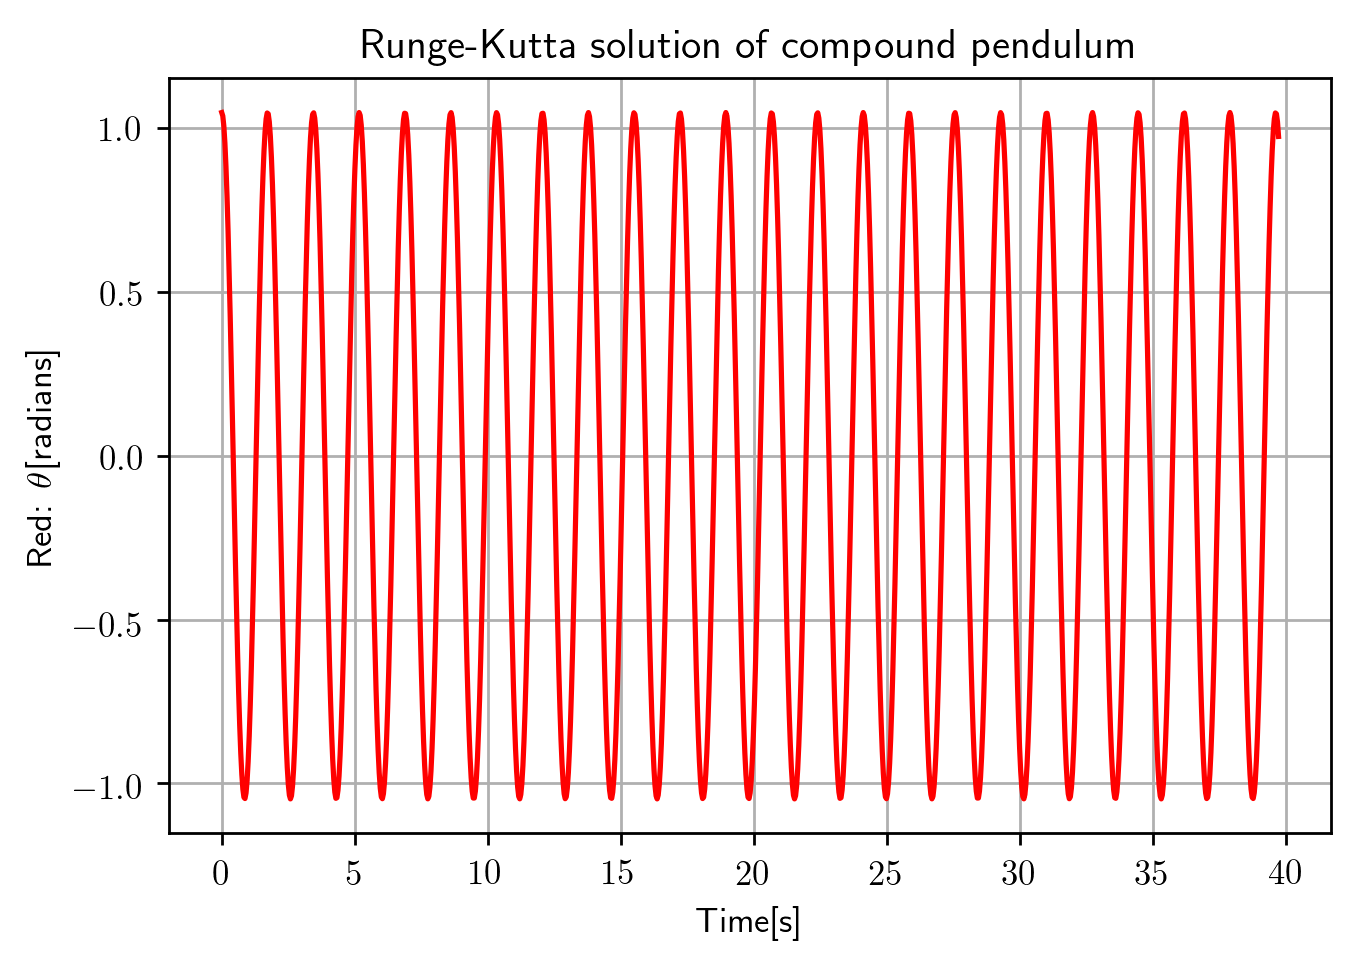

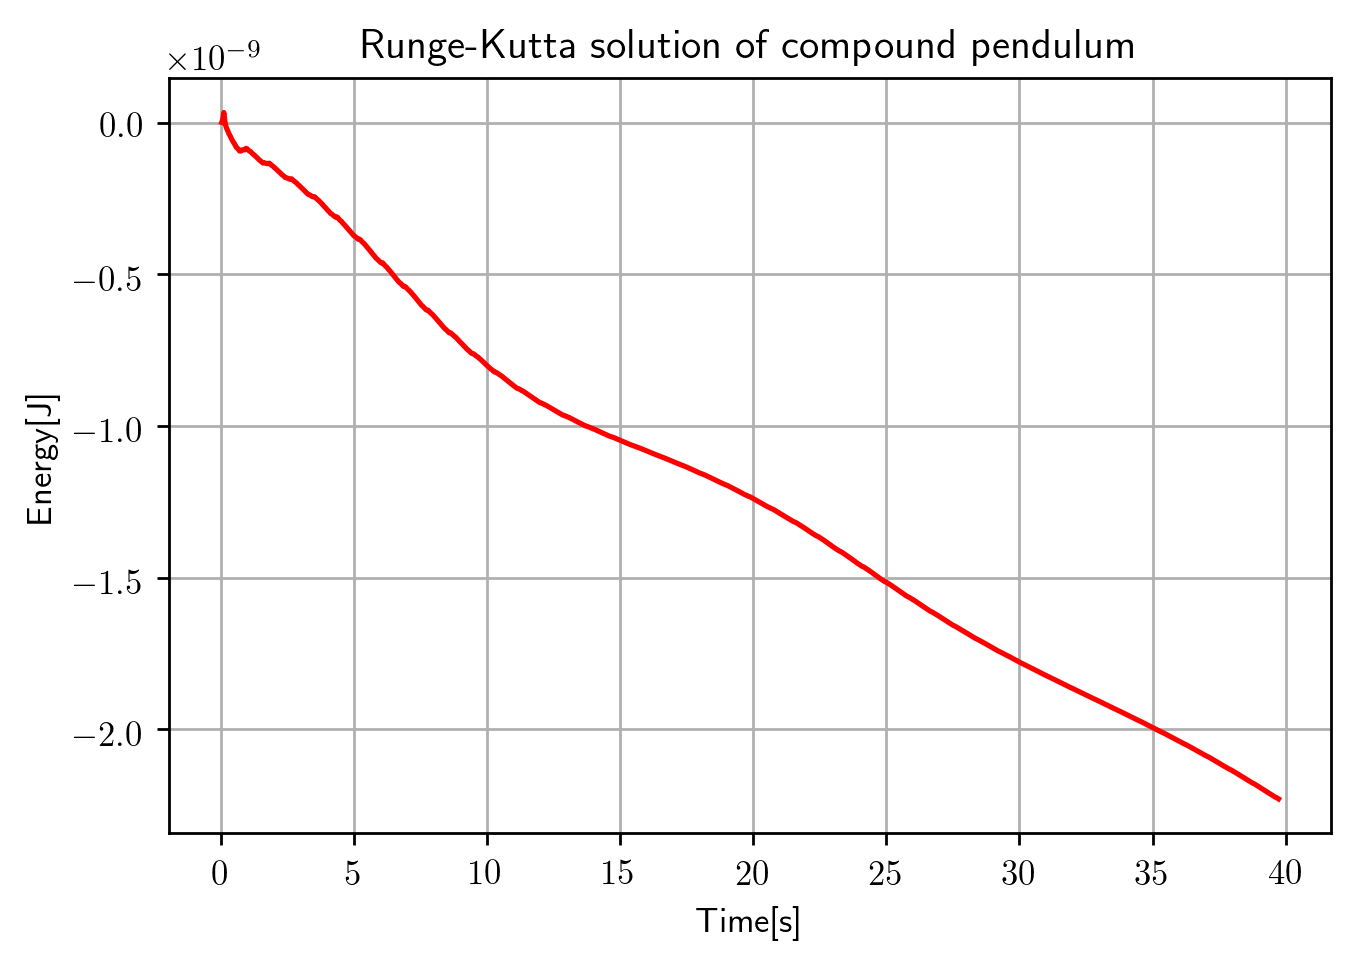

In [65]:
#final code that passes all validations

def CompoundPendulum(y,t):
    theta,omega,alpha,beta,E,in1,in2,in3=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    
    #change first row to mass, instead of mass*r
    A=np.array([[0,0,mass,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    #note beta in equation below instead of alpha!
    E=1/2*mass*r**2*omega**2-mass*g*r*np.cos(theta)+1/2*I*beta**2
    delR=mass*rddot-mass*r*omega**2-mass*g*np.cos(theta)+T*cosphi
    delTheta=mass*r*thetaddot+2*mass*rdot*omega+mass*g*np.sin(theta)+T*sinphi
    rcheck=r**2-(radius**2+l**2+2*radius*l*np.cos(np.arcsin(sinphi)+theta-alpha))

    dydt=np.array([omega,thetaddot,beta, alphaddot,E,delR,delTheta,rcheck])
    return dydt    

#and now we set up some constants (measured quantities)

g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
#mass=0.029 #kg  mass of pendulum bob
#radius=0.00949 #m radius of pendulum bob
#l=0.635-radius #length of pendulum wire, meters (subtract off radius now)
#I=2/5*mass*radius**2 #moment of inertia of sphere

omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3

#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 25*T, 1001)
#note fix in equation below
E0=-mass*g*(l+radius)*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0,E0,0,0,0])
relativeTolerance=np.array([2e-8,2e-8,2e-8,2e-8,1,1,1,1])
    
solution = odeint(CompoundPendulum, y0, t,rtol=relativeTolerance, atol=relativeTolerance)

plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 0], 'r', label='rk theta(t)')
plt.ylabel(r'Red: $\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     

plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[1:], (solution[1:,4]-solution[0,4])/t[1:]-solution[0,4], 'r', label='Energy')
plt.ylabel('Energy[J]')
plt.xlabel('Time[s]')
plt.grid()             

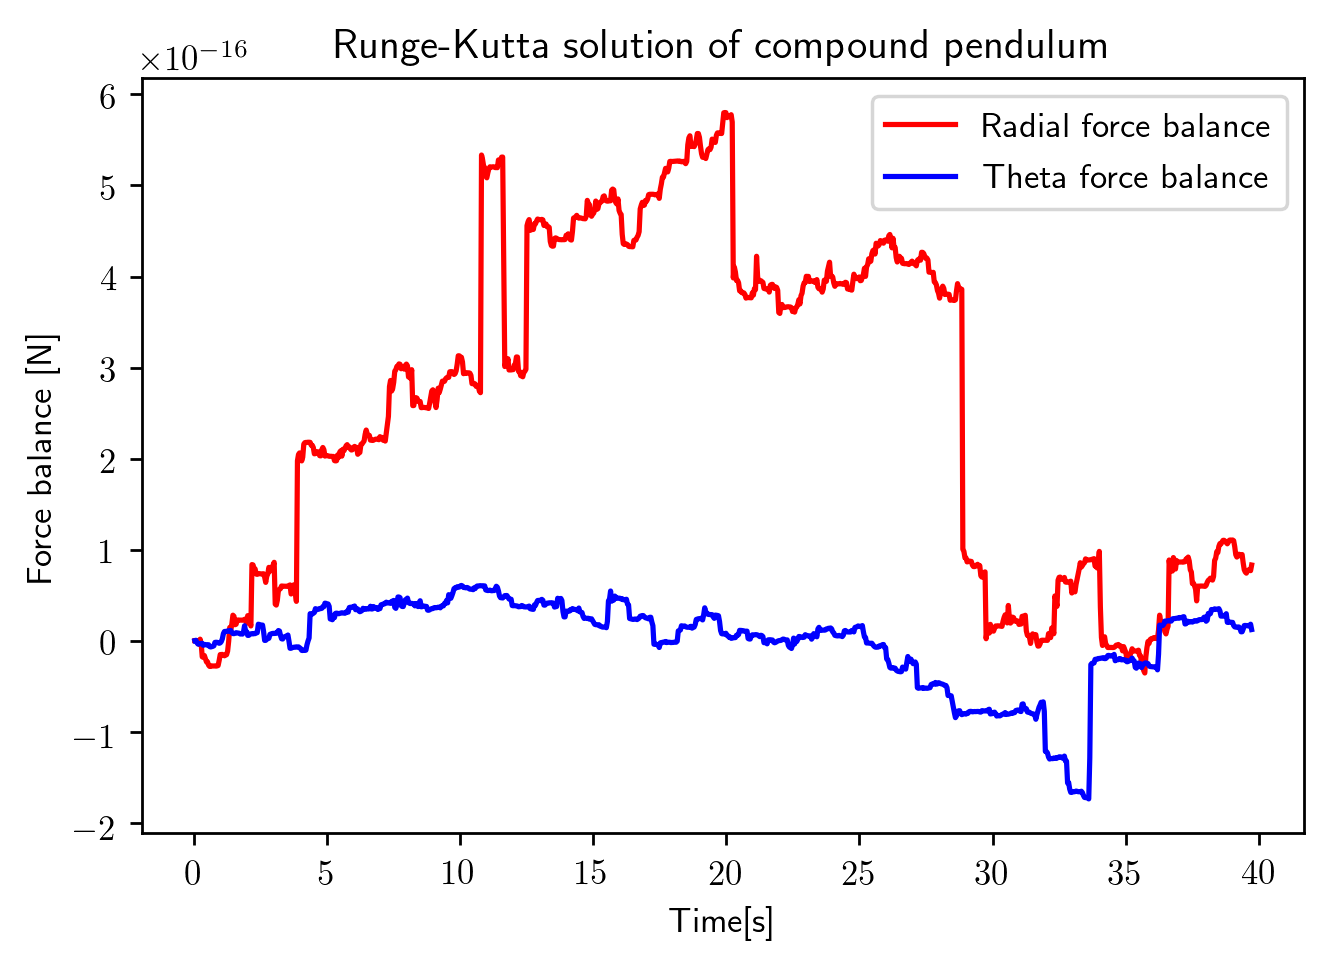

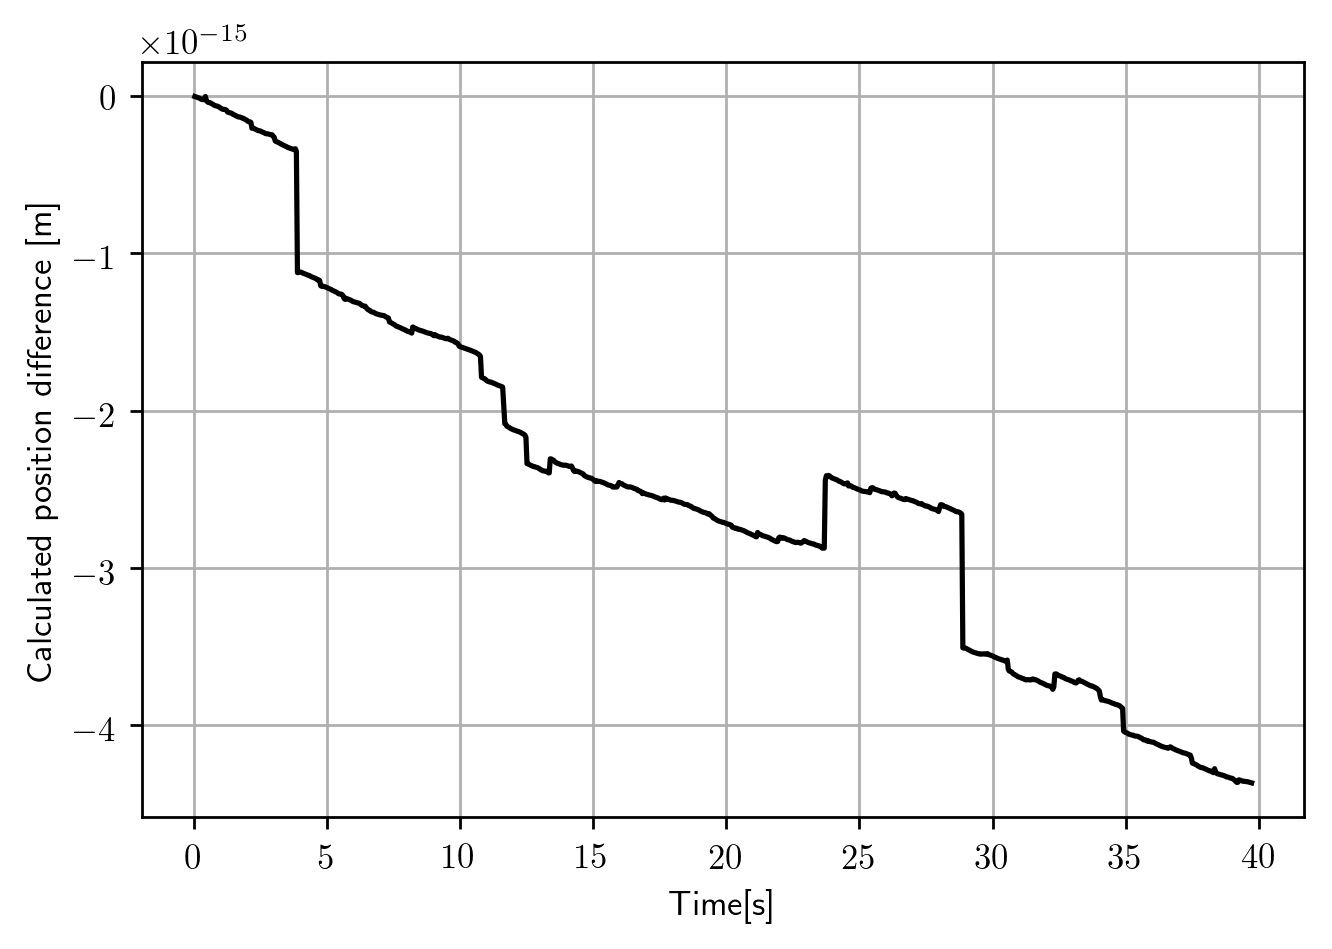

In [66]:
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[1:],solution[1:,5], 'r', label='Radial force balance')
plt.ylabel('Force balance [N]')
plt.xlabel('Time[s]')
plt.plot(t[1:],solution[1:,6], 'b', label='Theta force balance')
plt.legend()        

plt.figure()         
plt.plot(t[1:],solution[1:,7], 'k', label='Cosine law check')
plt.ylabel('Calculated position difference [m]')
plt.xlabel('Time[s]')
plt.grid()             

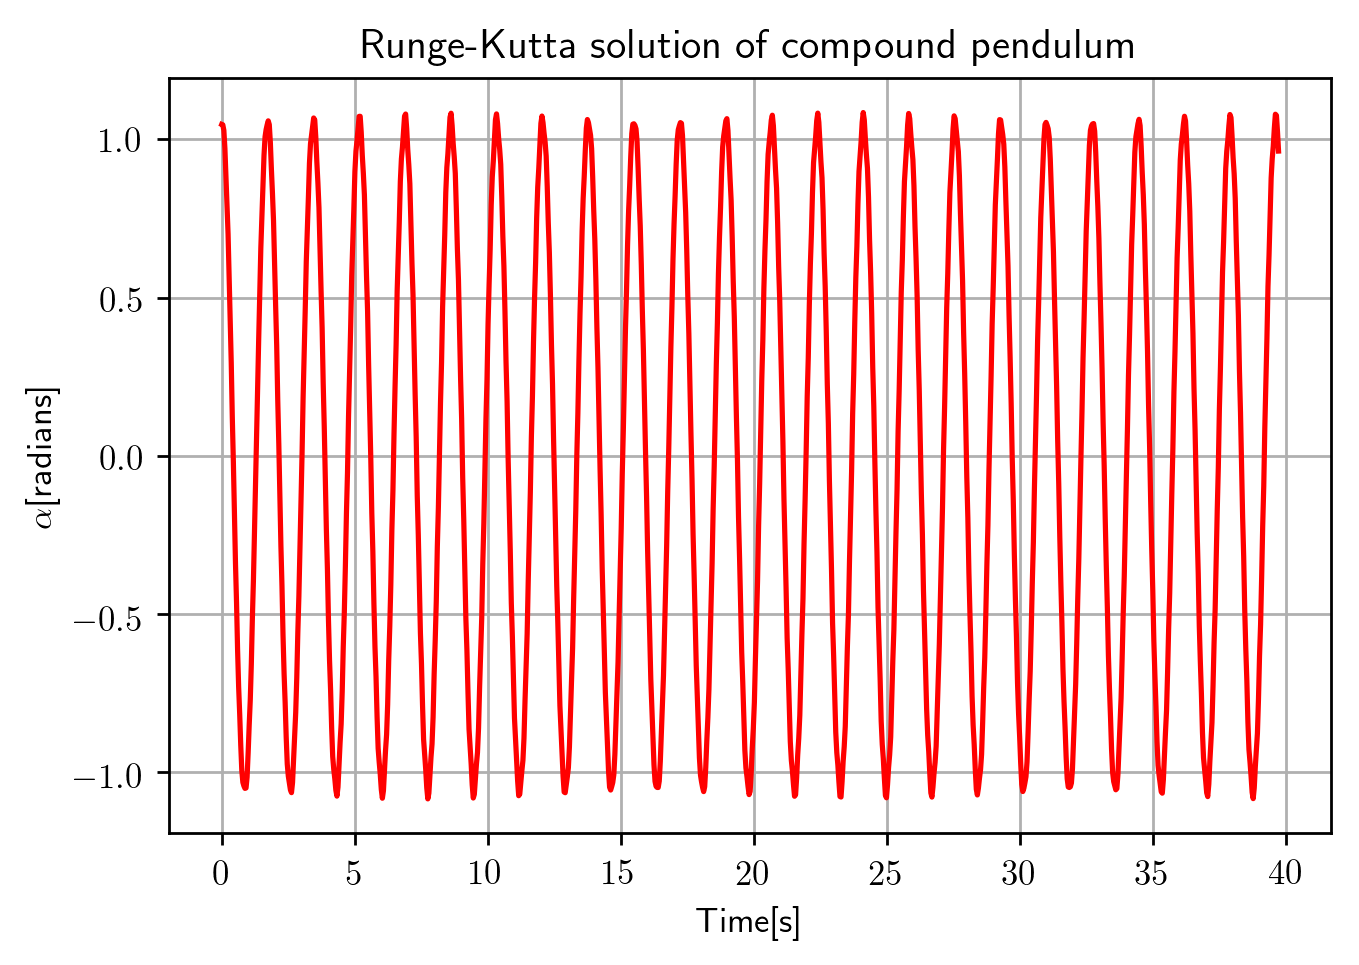

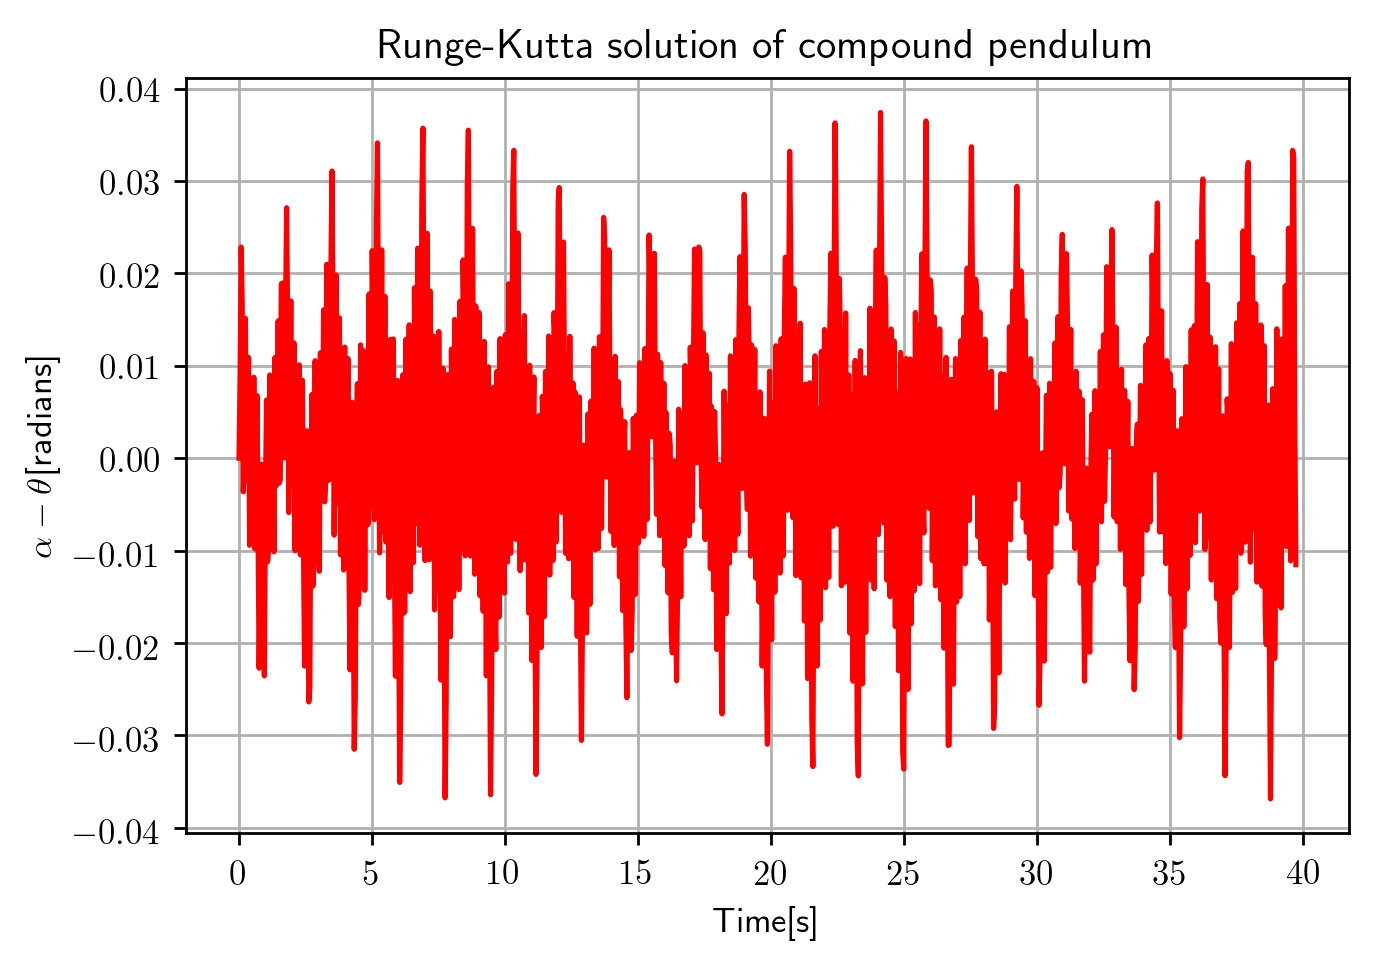

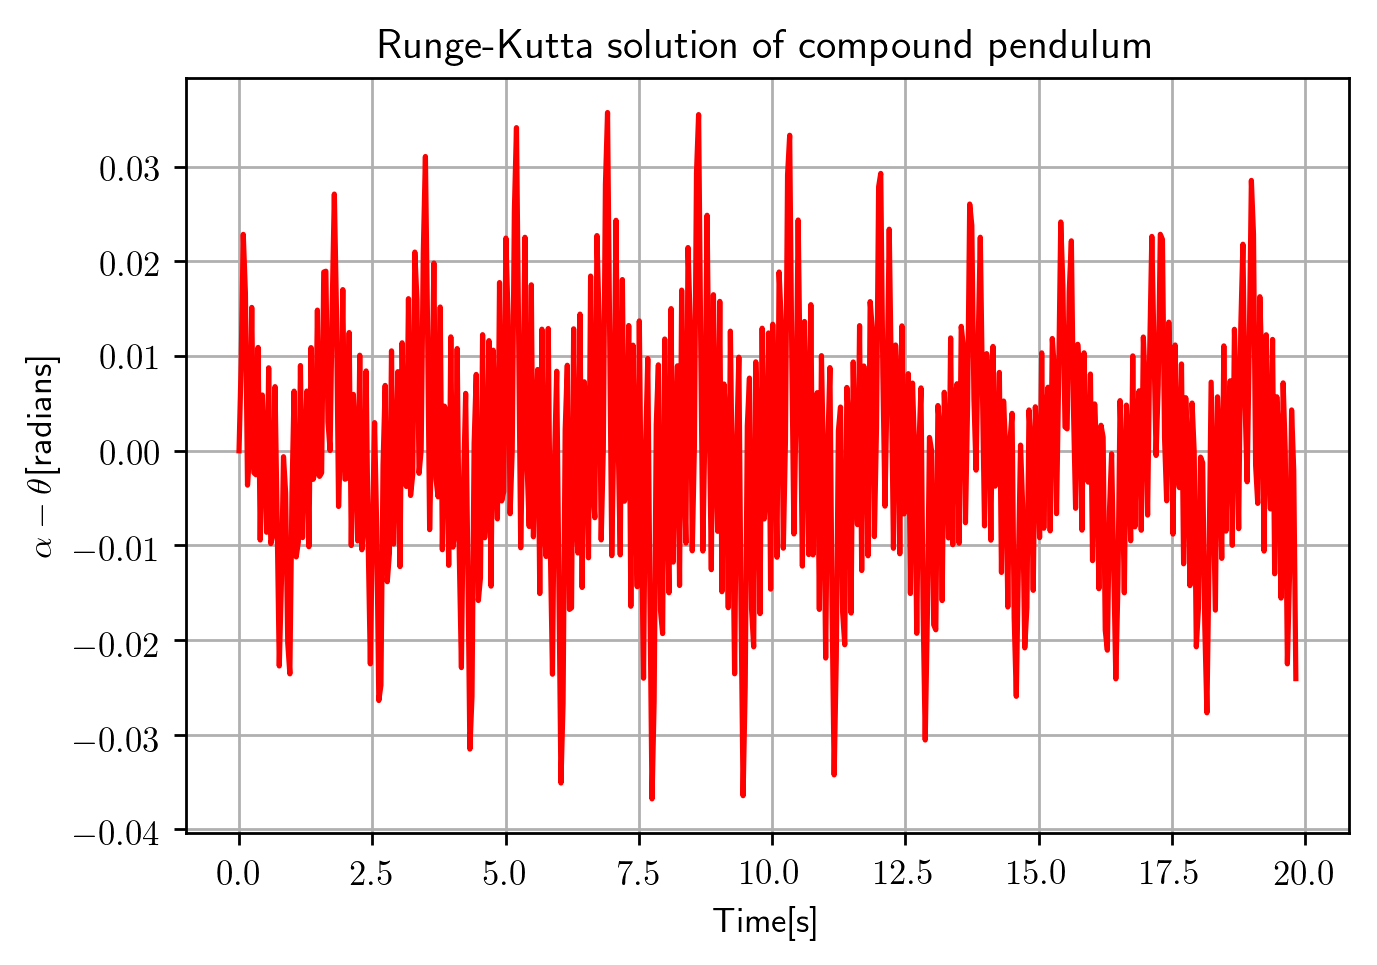

In [67]:
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 2], 'r', label='rk alpha(t)')
plt.ylabel(r'$\alpha$[radians]')
plt.xlabel('Time[s]')
plt.grid()  
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t, solution[:, 2]-solution[:,0], 'r', label='rk alpha(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum')
plt.plot(t[0:500], solution[0:500, 2]-solution[0:500,0], 'r', label='rk alpha(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()                     


Now compare the solution to the large-angle oscillation solution.

neval= 3323


Text(0, 0.5, 'Red: Simple pendulum; Blue:Compound $\\theta$[radians]')

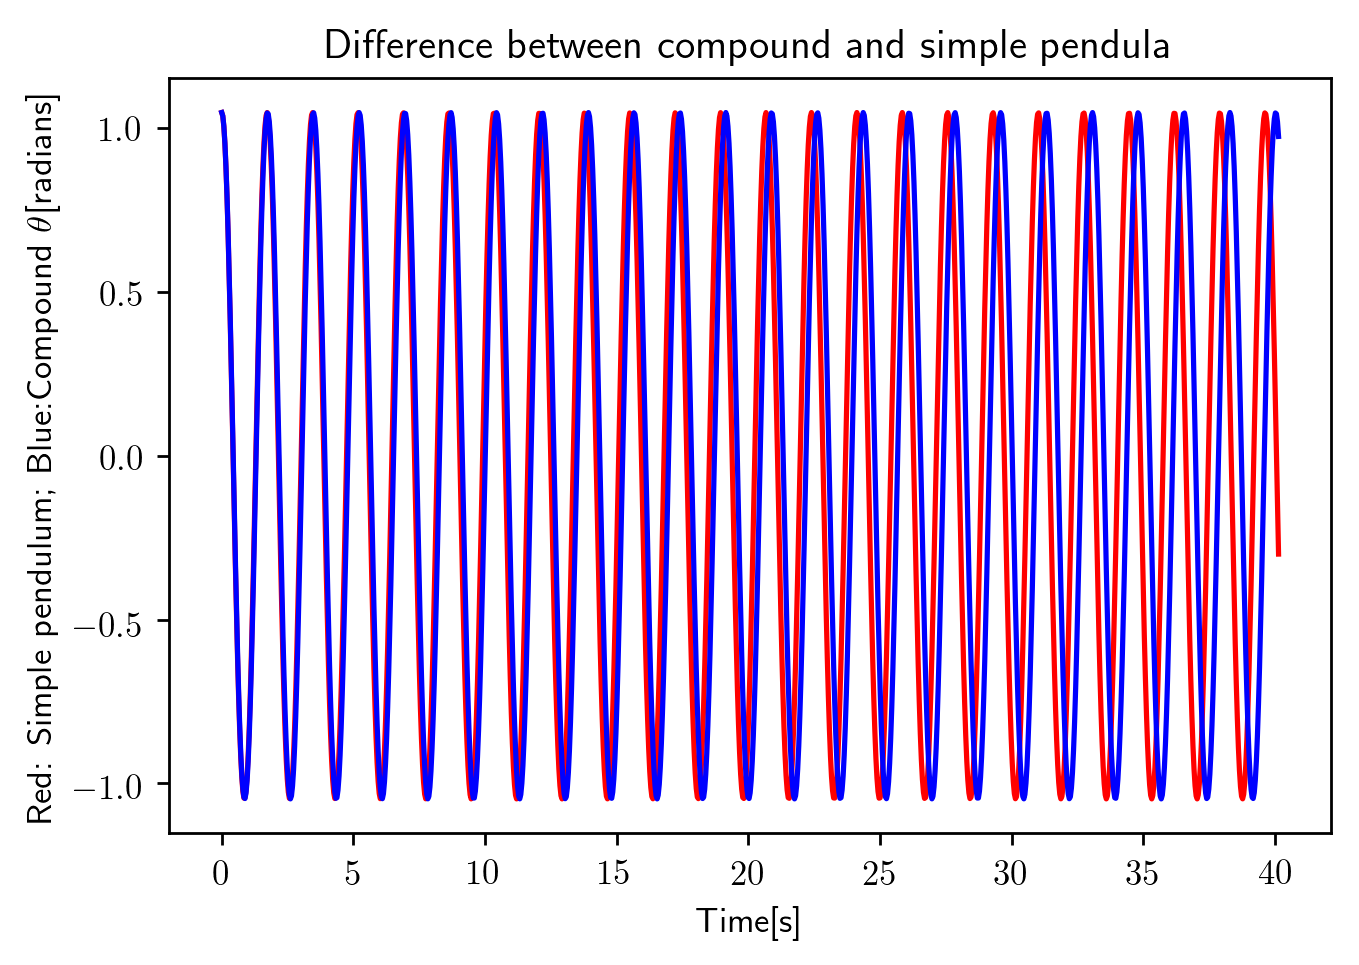

In [68]:
from scipy.integrate import odeint
import pendulumParameters as p

neval=0

def pend(y,t):
    global neval
    theta, omega = y
    dydt = np.array([omega, - g/l*np.sin(theta)])
    neval=neval+1
    return dydt

#and now we set up some constants (measured quantities)
l=p.l  #length of pendulum, meters
g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0])
    
#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:

t = np.linspace(0, 25*T, 1001)
    
###    Call `odeint` to generate the solution.  To pass the parameters
#    `b` and `c` to `pend`, we give them to `odeint` using the `args`
#    argument.
    
solrk = odeint(pend, y0, t)
print('neval=',neval)
ifig=1
plt.figure(ifig)
ifig=ifig+1
plt.plot(t, solrk[:, 0], 'r', label='simple pendulum theta(t)')
plt.plot(t, solution[:, 0], 'b', label='compound pendulum')
plt.title("Difference between compound and simple pendula")
plt.xlabel('Time[s]')
plt.ylabel(r'Red: Simple pendulum; Blue:Compound $\theta$[radians]')


what is the difference in period between the simple pendulum and the compound pendulum?

In [69]:
print('phase at time T=', t[-1],' for simple pendulum is ',solrk[-1,0],' and compound pendulum', solution[-1,0])
tcompound=t[-20+np.argmax(solution[-20:-1,0])]
tsimple=t[-20+np.argmax(solrk[-20:-1,0])]
print('maximum of compound pendulum is ', np.amax(solution[-20:-1,0]),' at time t=',tcompound)
print('maximum of simple pendulum is ', np.amax(solrk[-20:-1,0]),' at time t=',tsimple)
print('fractional difference in period is ',(tcompound-tsimple)*2/(tcompound+tsimple))

phase at time T= 40.132232285318615  for simple pendulum is  -0.3001674581913273  and compound pendulum 0.9742870475391776
maximum of compound pendulum is  1.0458958612176101  at time t= 40.01183558846266
maximum of simple pendulum is  1.0460522340050287  at time t= 39.61051326560947
fractional difference in period is  0.010080645161290418


Does this make sense physically?  It appears that the compound pendulum has a longer period than the
simple pendulum?  We will add another variable to our validation- calculating the time average of the difference $l+r_s-r$, which one would think would be positive, and therefore make the compound pendulum faster.  But we have also added a degree of freedom that shares in the kinetic energy- that might make the compound pendulum slower.

These kinds of questions come up repeatedly when we calculate physical models.  People are very good at "explaining"/"hypothesizing"/"making up stories" when they see a phenomenon they don't understand.  To turn these from "stories" to "explanations" we need quantitative tests.

We start with calculating the average difference in the length.




In [70]:
#final code that passes all validations
#also include check on l+r_s-r, and output average potential, cm kinetic, and angular momentum kinetic energies

def CompoundPendulum(y,t):
    theta,omega,alpha,beta,E,in1,in2,in3,in4,in5,in6,in7=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    
    #change first row to mass, instead of mass*r
    A=np.array([[0,0,mass,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    #note beta in equation below instead of alpha!
    E=1/2*mass*r**2*omega**2-mass*g*r*np.cos(theta)+1/2*I*beta**2
    delR=mass*rddot-mass*r*omega**2-mass*g*np.cos(theta)+T*cosphi
    delTheta=mass*r*thetaddot+2*mass*rdot*omega+mass*g*np.sin(theta)+T*sinphi
    rcheck=r**2-(radius**2+l**2+2*radius*l*np.cos(np.arcsin(sinphi)+theta-alpha))
    lengthCheck=l+radius-r
    mgh=-mass*g*r*np.cos(theta)
    Ecm=1/2*mass*r**2*omega**2
    EL=1/2*I*beta**2

    dydt=np.array([omega,thetaddot,beta, alphaddot,E,delR,delTheta,rcheck,lengthCheck,mgh,Ecm,EL])
    return dydt    

#and now we set up some constants (measured quantities)

g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
mass=p.mMass #0.029 #kg  mass of pendulum bob
radius=p.dMass/2 #.00949 #m radius of pendulum bob
l=p.stringLength #length of pendulum wire, meters (subtract off radius now)
I=2/5*mass*radius**2 #moment of inertia of sphere

omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3

#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 25*T, 10001)
#note fix in equation below
E0=-mass*g*(l+radius)*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0,E0,0,0,0,0,0,0,0])
relativeTolerance=np.array([2e-8,2e-8,2e-8,2e-8,1,1,1,1,1,1,1,1])
    
solution = odeint(CompoundPendulum, y0, t,rtol=relativeTolerance, atol=relativeTolerance)



The difference in average angular distance travelled is 1.274455 radians out of 145.487549


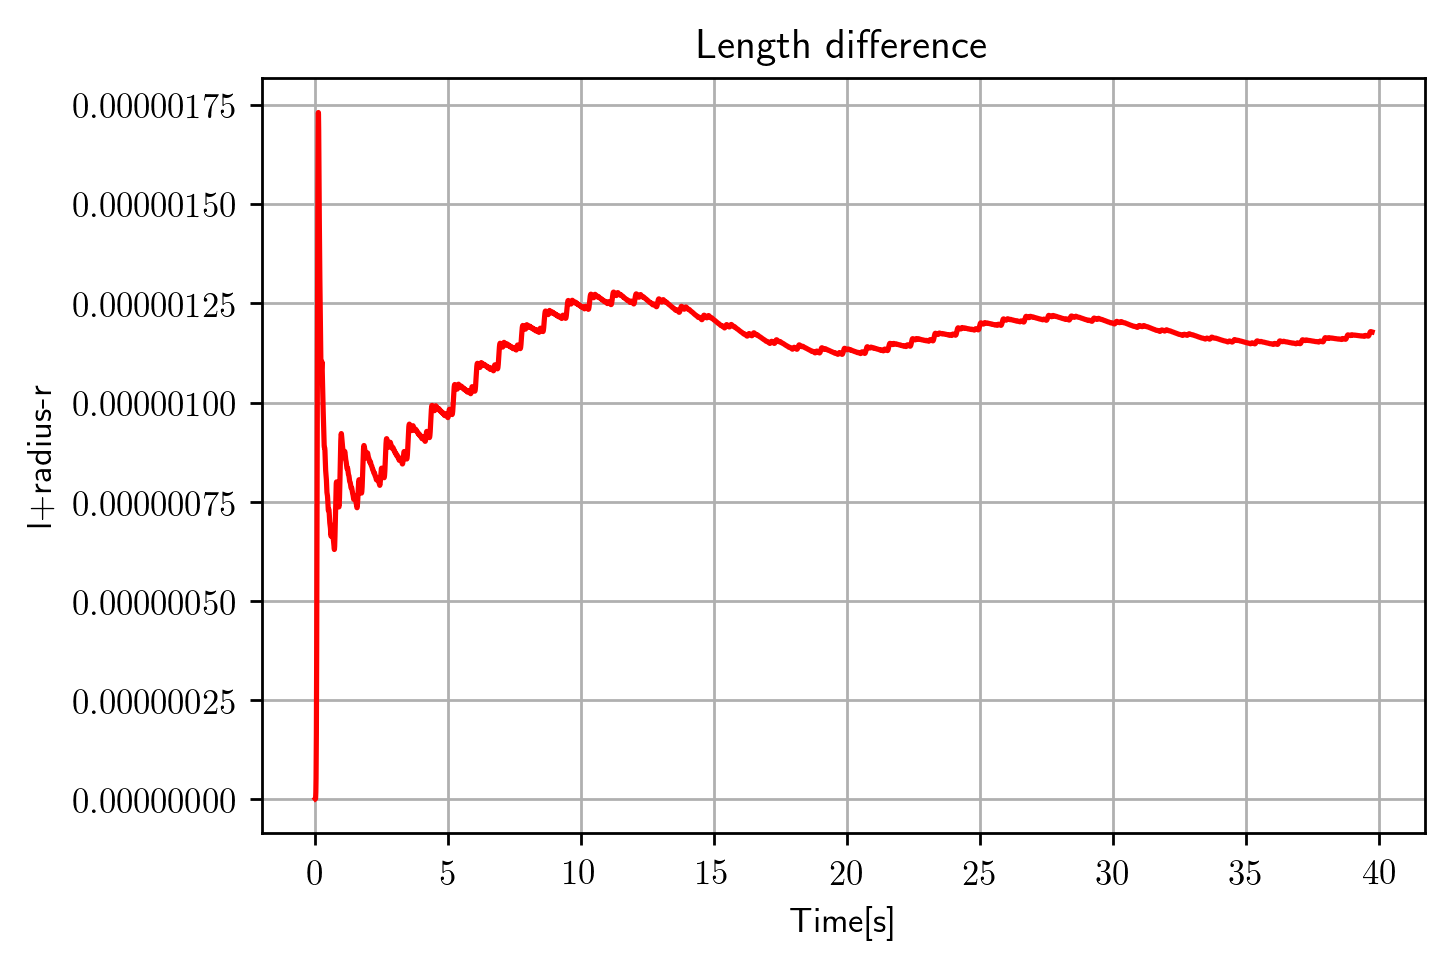

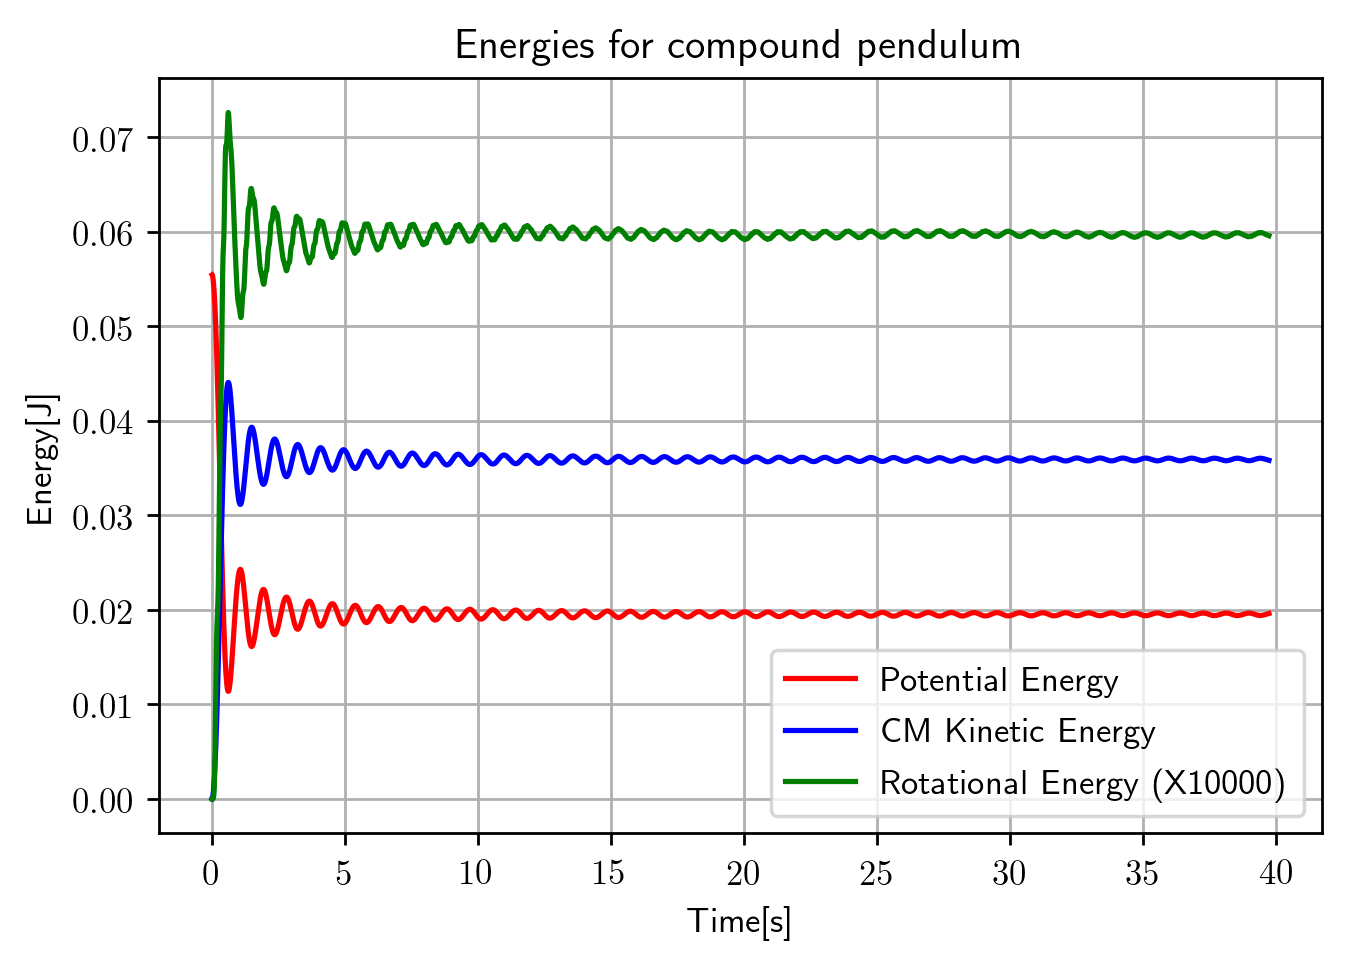

In [71]:
plt.figure()
plt.title('Length difference')
plt.plot(t[1:], (solution[1:, 8]-solution[0,8])/t[1:], 'r', label='Delta-L')
plt.ylabel('l+radius-r')
plt.xlabel('Time[s]')
plt.grid()                     

plt.figure()
plt.title('Energies for compound pendulum')
plt.plot(t[1:], (solution[1:,9]-solution[0,9])/t[1:]+0.130, 'r', label='Potential Energy')
plt.plot(t[1:], (solution[1:,10]-solution[0,10])/t[1:], 'b', label='CM Kinetic Energy')
plt.plot(t[1:], (solution[1:,11]-solution[0,11])/t[1:]*10000, 'g', label='Rotational Energy (X10000)')
plt.ylabel('Energy[J]')
plt.xlabel('Time[s]')
plt.legend()
plt.grid() 

print('The difference in average angular distance travelled is %f radians out of %f'%(solution[-1,0]-solrk[-1,0],23*2*np.pi+solution[-1,0]))

Neither of our "explanations" is really correct.  The difference in length is 1.4e-6- which results in a decrease in period of 7e-7-- much smaller than what we see.  The energy difference is a part in 10000- which again results in a tiny change in angular velocity which doesn't explain the 1% difference in average angular velocity.  My intuition is bankrupt- it must be that the angular oscillation somehow slows things down at the low velocities- perhaps a phenomenon like "pumping a swing" in reverse.   


# Adding the elastic properties of the string

With our current formalism it is straightforward to add the elastic properties of the string.  We measure that the string elongates 0.01m/17N; so the length of the string is given by $l=l0+0.0006T$.  We could correct $l0$ for the mass of the pendulum, but this is only a 0.2 mm- below the accuracy of the measurement anyway.  Start by adding Tension as an output so we can get the time averaged tension.  

In [59]:
#final code that passes all validations
#also include check on l+r_s-r, and output average potential, cm kinetic, and angular momentum kinetic energies

def CompoundPendulumStretch(y,t):
    theta,omega,alpha,beta,E,in1,in2,in3,in4,in5,in6,in7,in8=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    
    #change first row to mass, instead of mass*r
    A=np.array([[0,0,mass,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    #note beta in equation below instead of alpha!
    E=1/2*mass*r**2*omega**2-mass*g*r*np.cos(theta)+1/2*I*beta**2
    delR=mass*rddot-mass*r*omega**2-mass*g*np.cos(theta)+T*cosphi
    delTheta=mass*r*thetaddot+2*mass*rdot*omega+mass*g*np.sin(theta)+T*sinphi
    rcheck=r**2-(radius**2+l**2+2*radius*l*np.cos(np.arcsin(sinphi)+theta-alpha))
    lengthCheck=l+radius-r
    mgh=-mass*g*r*np.cos(theta)
    Ecm=1/2*mass*r**2*omega**2
    EL=1/2*I*beta**2

    dydt=np.array([omega,thetaddot,beta, alphaddot,E,delR,delTheta,rcheck,lengthCheck,mgh,Ecm,EL,T])
    return dydt    

#and now we set up some constants (measured quantities)

g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
mass=p.mMass #0.029 #kg  mass of pendulum bob
radius=p.dMass/2 #.00949 #m radius of pendulum bob
l=p.stringLength #length of pendulum wire, meters (subtract off radius now)
I=2/5*mass*radius**2 #moment of inertia of sphere

omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/3

#    We generate a solution 1001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 25*T, 10001)
#note fix in equation below
E0=-mass*g*(l+radius)*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0,E0,0,0,0,0,0,0,0,0])
relativeTolerance=np.array([2e-8,2e-8,2e-8,2e-8,1,1,1,1,1,1,1,1,1])
    
solution = odeint(CompoundPendulumStretch, y0, t,rtol=relativeTolerance, atol=relativeTolerance)




Now we take the numerical derivative to find the instantaneous tension.  


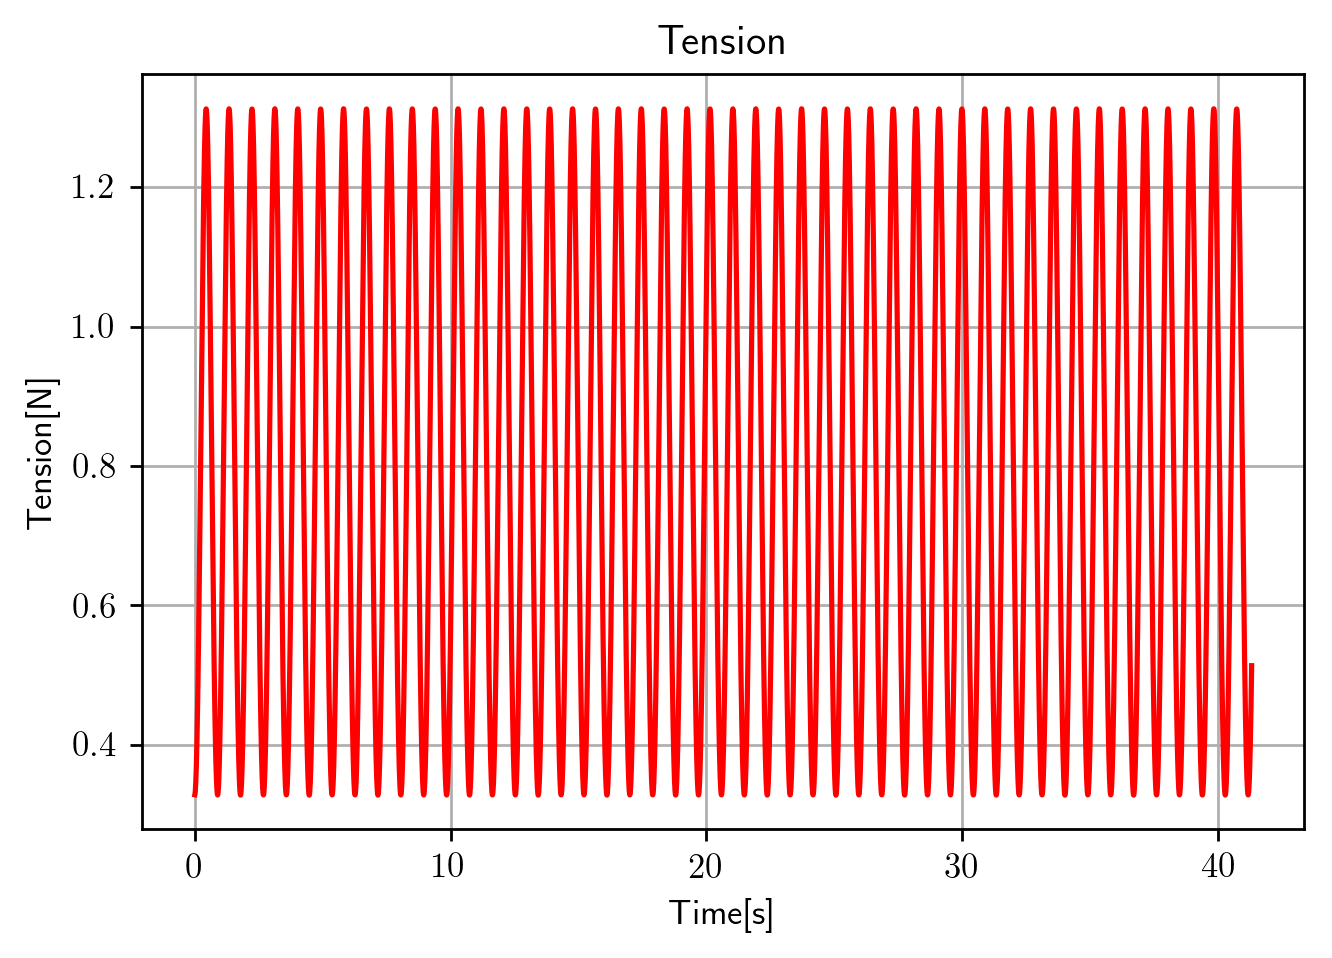

In [60]:

tension=(solution[2:,12]-solution[0:-2,12])/(t[2:]-t[0:-2])
plt.figure()
plt.title('Tension')
plt.plot(t[1:-1], tension, 'r', label='Tension')
plt.ylabel('Tension[N]')
plt.xlabel('Time[s]')
plt.grid()                     


This shows a maximum tension of 1.2 N- 
which will result in a shift in length of $0.0006 \times1.2=0.00072$ m  about 3/4 mm and at our ability to measure lengths.  We note that a shift in length of 0.0007/.65=0.1%, will shift the period by 0.05%- much smaller than the shifts we have seen from large amplitude, air resistance, and the compound pendulum.  

# Compound Pendulum with Air resistance
Finally, we put everything together to calculate the compound pendulum with air resistance.  
We basically pull in our function drag(velocity) and wireTorque(omega)- and use them to add a term to $F_\theta$.

In [17]:
import numpy as np
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)
mpl.rc('text',usetex=True)

#and now we set up some constants (measured quantities)
g=9.8 # acceleration of gravity on Earth's surface, meters/s**2
mass=p.mMass #0.029 #kg  mass of pendulum bob
radius=p.dMass/2 #.00949 #m radius of pendulum bob
l=p.stringLength #length of pendulum wire, meters (subtract off radius now)
I=2/5*mass*radius**2 #moment of inertia of sphere

airViscosity=1.827e-5   #Pa-s  
wireDiameter=p.stringDiameter #0.00071 # m
b=6*np.pi*airViscosity*radius
airPressure=92.6 #kPa
standardAirDensity=1.225 # kg/m**3
standardAirPressure=101.325 #kPa
airDensity=airPressure/standardAirPressure*standardAirDensity
omega_0=np.sqrt(g/l)
T=2*np.pi/omega_0  #  period, seconds
theta_0=np.pi/4

def ReynoldsNumber(velocity):
    '''Calculates Reynolds number for a pendulum of length l and angular velocity omega.  Because it is used 
    in an logarithmic interpolation, we impose 1 as a lower cutoff'''
    R=airDensity*velocity*radius*2/airViscosity
    return np.maximum(R,1)

RN=np.array([1,4,10,40,100,400,1000,2000,4000])
DC=np.array([24,8,4,1.7,1.1,0.6,0.45,0.4,0.35])
import scipy.interpolate
logRN=np.log(RN)  #interpolation in log ReynoldsNumber will be more sensible
splineInterpolation=scipy.interpolate.interp1d(logRN,DC,kind='cubic')

def DragCoefficientSpline(reynoldsNumber):
    return splineInterpolation(np.log(reynoldsNumber))

area=np.pi*radius**2
velocityAtR1=airViscosity/(2*airDensity*radius)
ceta= 6*np.pi*airViscosity*radius
ct=.5*airDensity*area
def fdrag(velocity):
    v=abs(velocity)
    if v<velocityAtR1:
        force=ceta*v
    else:
        force=ct*v**2*DragCoefficientSpline(ReynoldsNumber(v))
    return force
drag=np.vectorize(fdrag)  #so that drag can accept either a scalar or an array

wireData=np.array([20,1.88,50,1.57,100,1.39,200,1.25,500,1.10,1000,.972,2000,.876,5000,.972,10000,1.092,20000,1.164,50000,1.178,100000,1.164]).reshape(12,2)
logWireData=np.log(wireData[:,0])  #interpolation in log ReynoldsNumber will be more sensible
interpolation=scipy.interpolate.interp1d(logWireData,wireData[:,1],kind='cubic')
def DragWire(reynoldsNumber):
    return interpolation(np.log(reynoldsNumber))

v20=20*airViscosity/(wireDiameter*airDensity)
v20_Coefficient=DragWire(20)*airDensity*v20*wireDiameter/2
def dWireForce_Scalar(velocity):
    v=abs(velocity)  #we make all velocities positive for this calculation
    if(v<v20):
        dforce=v20_Coefficient*v
    else:
        reynoldsNumber=airDensity*v*wireDiameter/airViscosity
        dforce=DragWire(reynoldsNumber)*airDensity*v**2*wireDiameter/2  #units are N/m since we put dz=1
    return dforce

dWireForce=np.vectorize(dWireForce_Scalar)

from scipy.integrate import quadrature


def dTorque(rPrime,omega):
    '''Calculates the torque from an element of wire at rprime moving with angular velocity omega'''
    return rPrime*dWireForce(rPrime*omega)
vdTorque=np.vectorize(dTorque)

def wireTorque(anOmega):
    om=np.abs(anOmega)
    if(np.isscalar(om)):
        return quadrature(dTorque,0,l,args=om)
    else:
        retval=np.zeros_like(om)
        for i in np.arange(0,om.size):
            retval[i]=quadrature(vdTorque,0,l,args=om[i])[0]
        return retval
    
def ChebyshevCoefficients(func,a,b,n):
    '''Evaluate n chebyshev coefficients for func evaluated between a and b;  based on NR 5.8.7'''
    range=0.5*(b-a)  
    average=0.5*(b+a)
    x=range*np.cos((np.arange(0,n)+0.5)*np.pi/n)+average  #maps from -1 to 1 onto a-b
    v=func(x).reshape(1,n)  #row array of function values
    A=np.cos(np.pi/n*np.arange(0,n)*((np.arange(0,n)+0.5)).reshape(n,1))
    C=np.dot(v,A)*2/n 
    return C
    
    
def ChebEval(x,c,a,b):
    '''Evaluate a chebyshev series c(x), for the range a-b'''
    range=0.5*(b-a)
    average=0.5*(a+b)
    mapped=(x-average)/range
    return np.polynomial.chebyshev.chebval(mapped,c)-c[0]/2

omegaArray=np.linspace(0,5,250)
ChebyshevCoefficientsForWireTorque=ChebyshevCoefficients(wireTorque,omegaArray[0],omegaArray[-1],60).reshape(60,)

def wireTorqueCheb(x):
    return ChebEval(np.abs(x),ChebyshevCoefficientsForWireTorque[:10],omegaArray[0],omegaArray[-1])






In [18]:
def CompoundPendulumWithDrag(y,t):
    theta,omega,alpha,beta,E,in1,in2,in3,in4,in5,in6,in7=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    dragValue=drag(r*omega)  #so we only call the function once
    wireTorque=wireTorqueCheb(r*omega)# so we only call the function once
    #change first row to mass, instead of mass*r
    A=np.array([[0,0,mass,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega-(dragValue+wireTorque/r)*np.sign(omega)],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    #note beta in equation below instead of alpha!
    E=1/2*mass*r**2*omega**2-mass*g*r*np.cos(theta)+1/2*I*beta**2+dragValue*r*np.abs(omega)+wireTorque*np.abs(omega)
    delR=mass*rddot-mass*r*omega**2-mass*g*np.cos(theta)+T*cosphi
    delTheta=mass*r*thetaddot+2*mass*rdot*omega+mass*g*np.sin(theta)+T*sinphi+dragValue+wireTorque/r*np.sign(omega)
    rcheck=r**2-(radius**2+l**2+2*radius*l*np.cos(np.arcsin(sinphi)+theta-alpha))
    lengthCheck=l+radius-r
    mgh=-mass*g*r*np.cos(theta)
    Ecm=1/2*mass*r**2*omega**2
    EL=1/2*I*beta**2

    dydt=np.array([omega,thetaddot,beta, alphaddot,E,delR,delTheta,rcheck,lengthCheck,mgh,Ecm,EL])
    return dydt    


#    We generate a solution 10001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 400*T, 10001)
E0=-mass*g*(l+radius)*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0,E0,0,0,0,0,0,0,0])
relativeTolerance=np.array([2e-8,2e-8,2e-8,2e-8,1,1,1,1,1,1,1,1])
    
solution = odeint(CompoundPendulumWithDrag, y0, t,rtol=relativeTolerance, atol=relativeTolerance)

In [66]:
solution


array([[  7.85398163e-01,   0.00000000e+00,   7.85398163e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.63558740e-01,  -6.58256569e-01,   7.76146127e-01, ...,
         -2.13454342e-02,   1.53464017e-04,   6.01725405e-09],
       [  6.99025859e-01,  -1.28663855e+00,   7.01467252e-01, ...,
         -4.35790320e-02,   1.19474630e-03,   2.04077053e-07],
       ..., 
       [  1.90460941e-01,   6.88296079e-01,   1.85517794e-01, ...,
         -2.83776547e+02,   1.55592805e+01,   2.19837868e-03],
       [  2.29659116e-01,   4.91672565e-01,   2.37296153e-01, ...,
         -2.83805850e+02,   1.55596552e+01,   2.19846721e-03],
       [  2.54816189e-01,   2.65585856e-01,   2.51460833e-01, ...,
         -2.83834935e+02,   1.55598127e+01,   2.19847799e-03]])

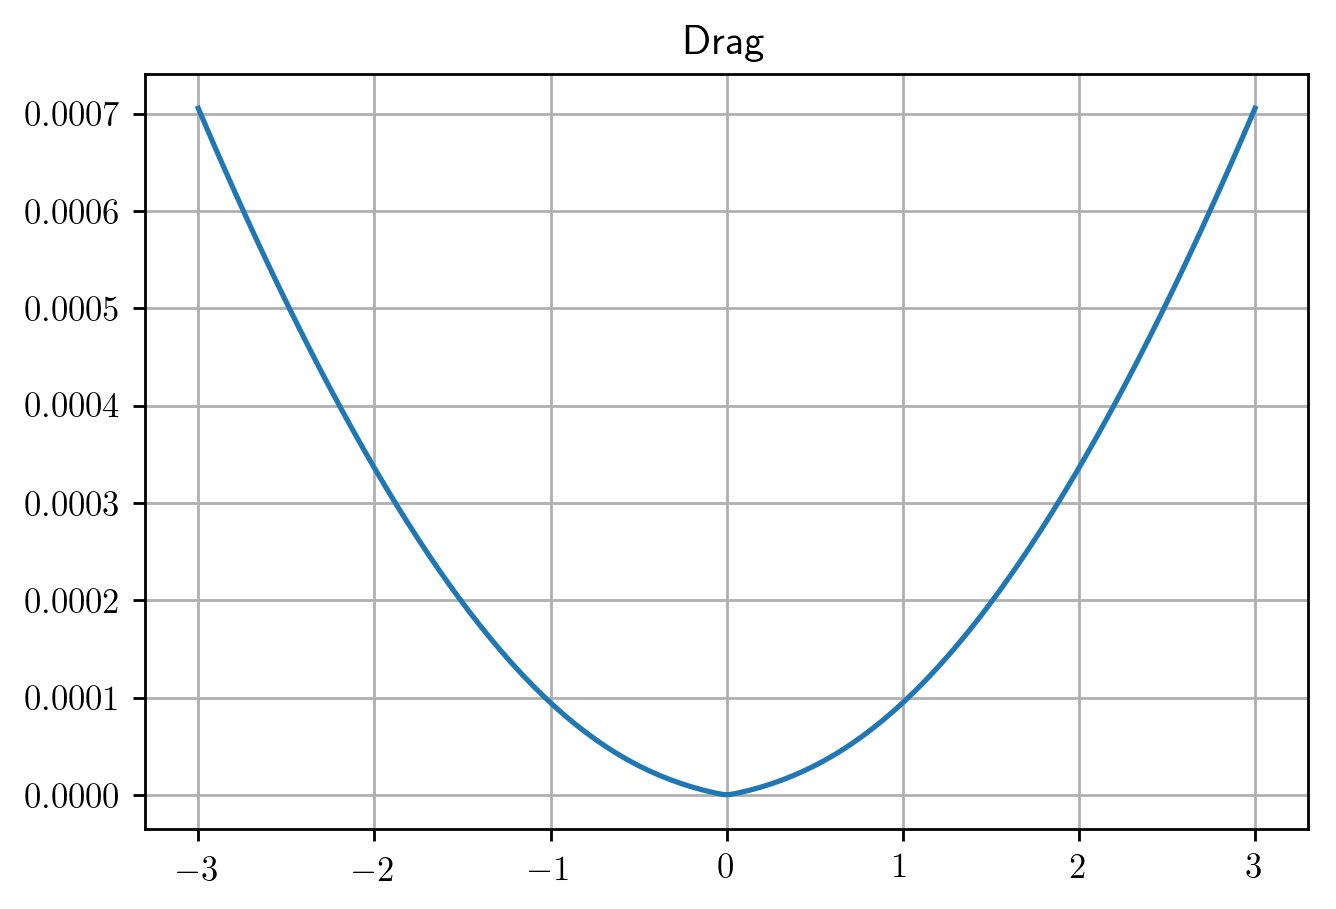

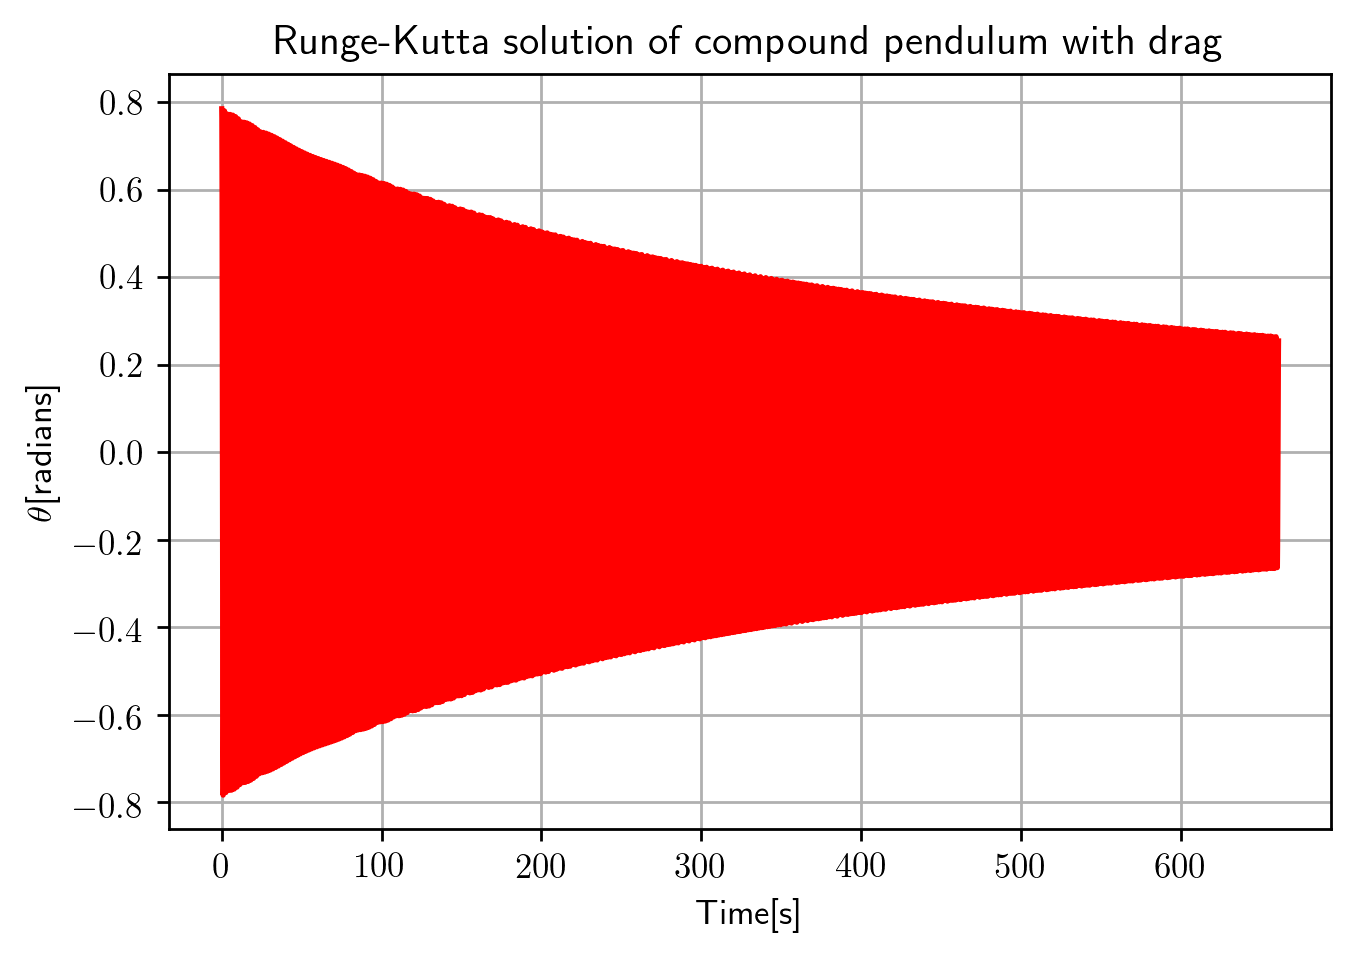

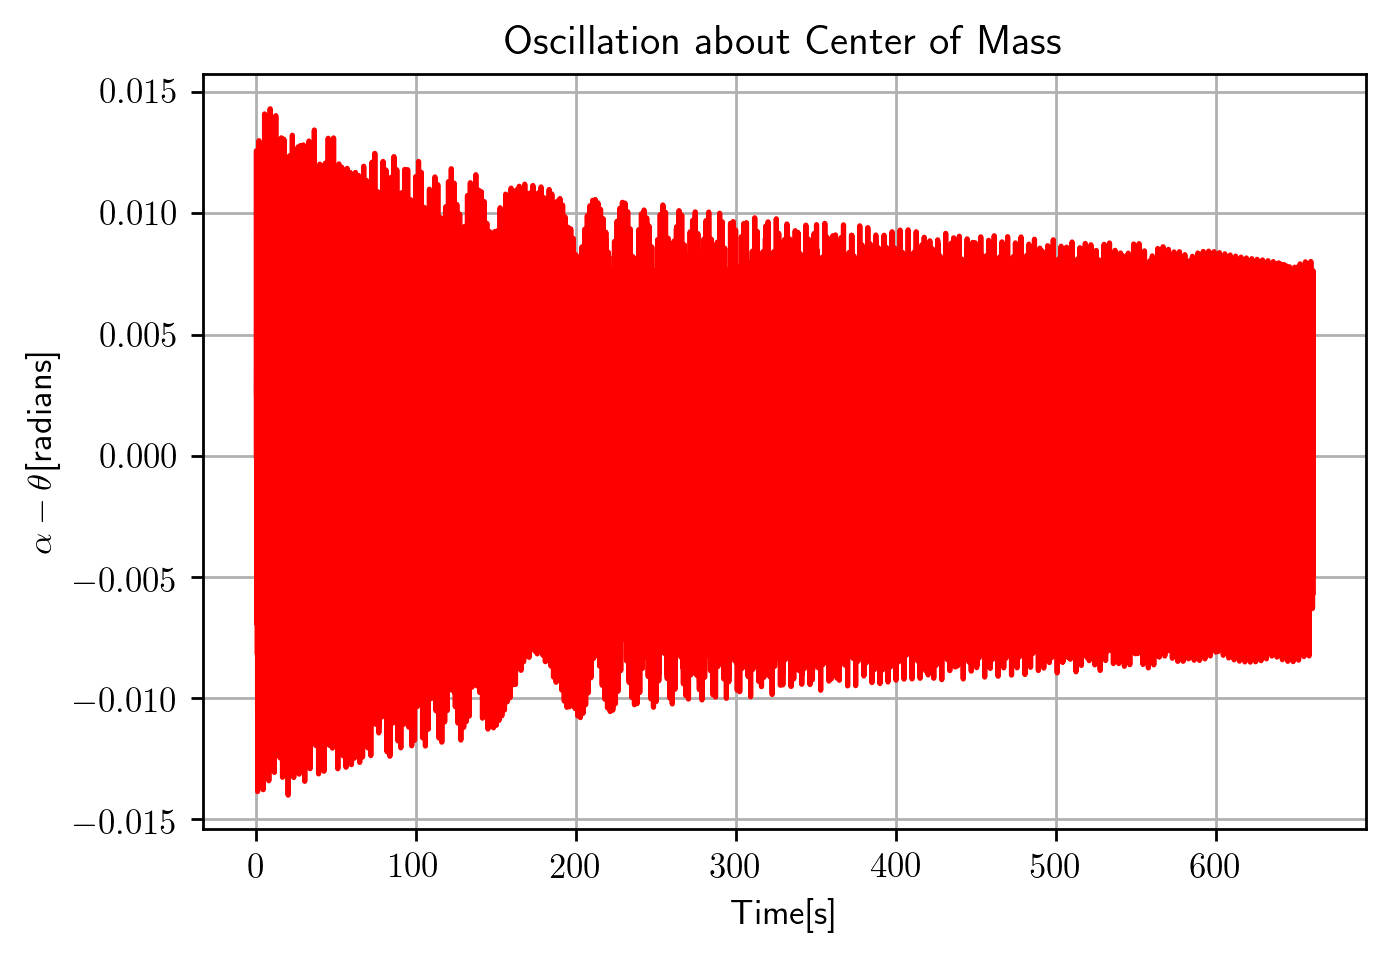

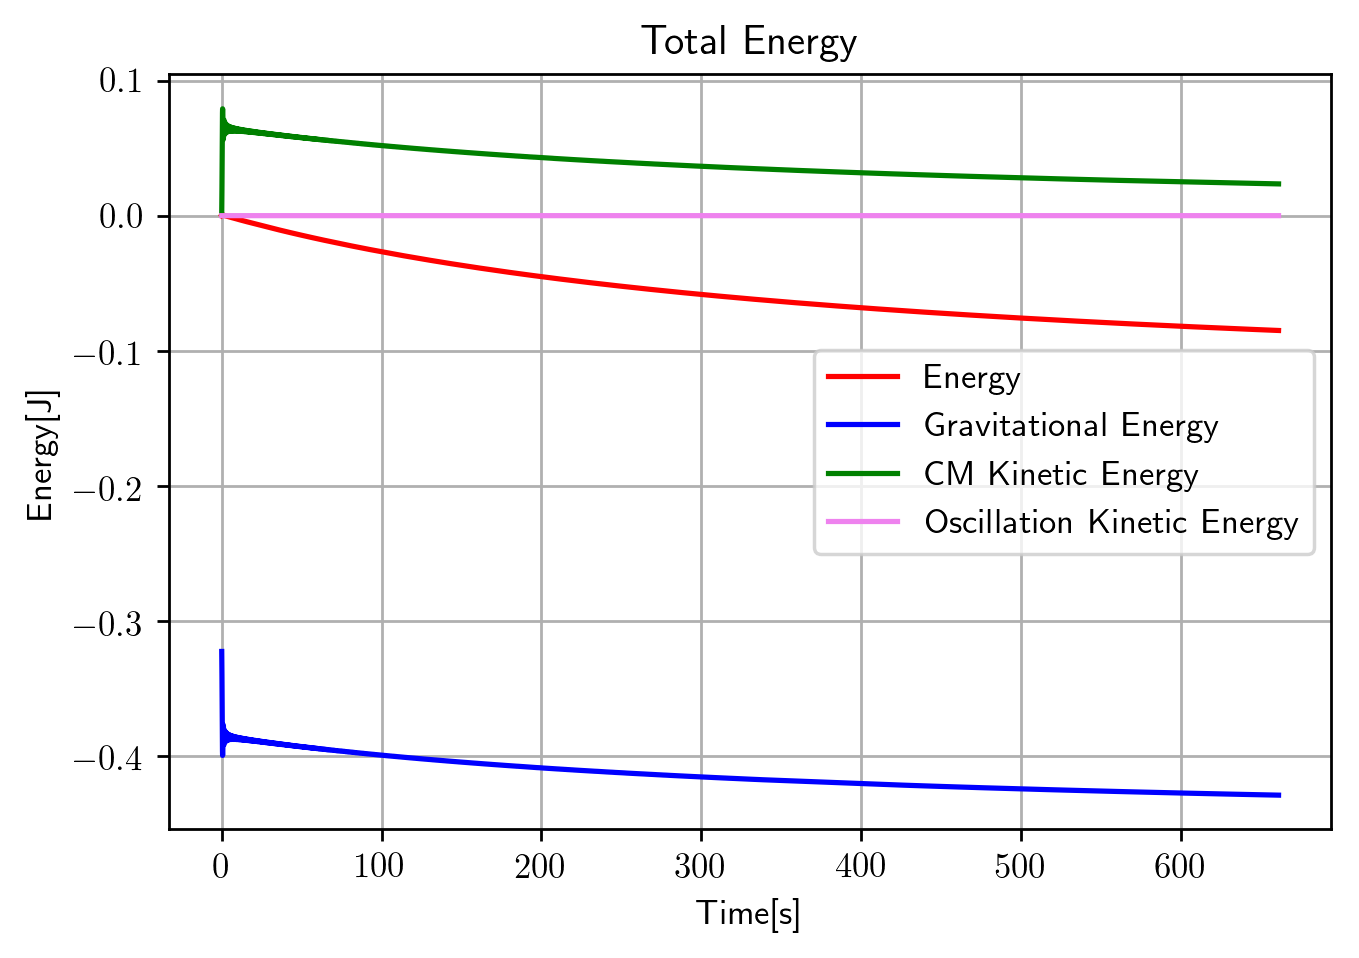

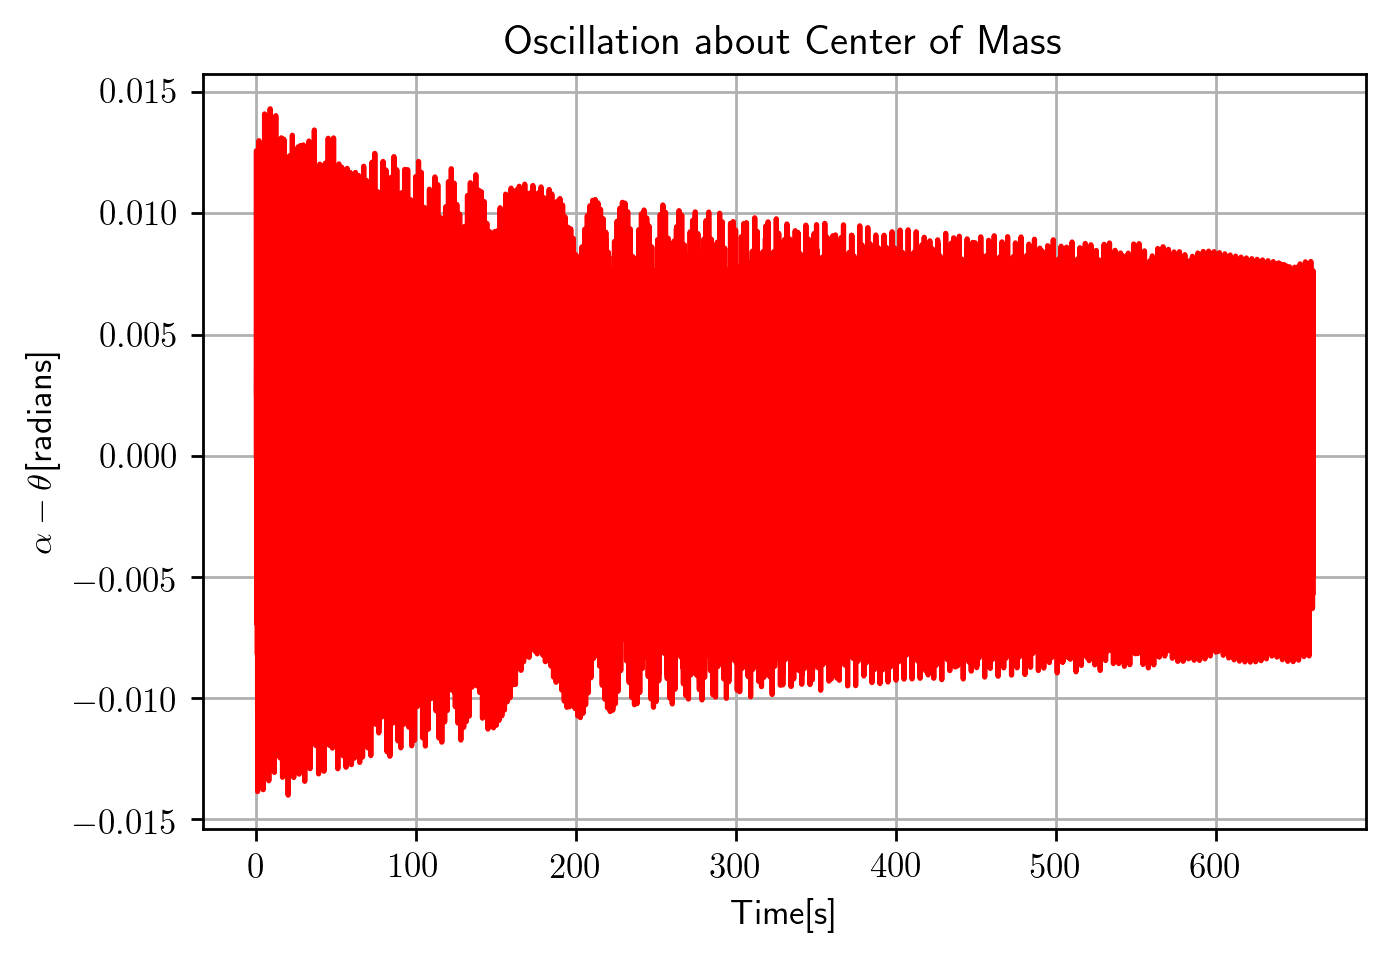

In [67]:
plt.figure()
xom=np.linspace(-3,3,200)
plt.title('Drag')
plt.plot(xom,drag(l*xom)+wireTorqueCheb(l*xom))
plt.grid()
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum with drag')
plt.plot(t, solution[:,0], 'r', label=r'\theta(t)')
plt.ylabel(r'$\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()  
plt.figure()
plt.title('Oscillation about Center of Mass')
plt.plot(t, solution[:,2]-solution[:,0], 'r', label=r'\alpha(t)-\theta(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()  

plt.figure()
plt.title('Total Energy')
plt.plot(t[1:], (solution[1:,4]-solution[0,4])/t[1:]-solution[0,4], 'r', label='Energy')
plt.plot(t[1:], (solution[1:,9]-solution[0,9])/t[1:]-solution[0,9], 'b', label='Gravitational Energy')
plt.plot(t[1:], (solution[1:,10]-solution[0,10])/t[1:]-solution[0,10], 'g', label='CM Kinetic Energy')
plt.plot(t[1:], (solution[1:,11]-solution[0,11])/t[1:]-solution[0,11], color='violet', label='Oscillation Kinetic Energy')
plt.ylabel('Energy[J]')
plt.xlabel('Time[s]')
plt.legend()
plt.grid()  
plt.figure()
plt.title('Oscillation about Center of Mass')
plt.plot(t, solution[:,2]-solution[:,0], 'r', label=r'\alpha(t)-\theta(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()  

This was excessively slow, so we speed it up by removing some of the validation code

In [71]:
def CompoundPendulumWithDrag2(y,t):
    theta,omega,alpha,beta=y
    costma=np.cos(theta-alpha)
    sintma=np.sin(theta-alpha)
    #now do cosine law.  Pick the positive rpoot
    r=np.amax(np.roots([1,-2*radius*costma,radius**2-l**2]))
    rdot=-r*radius*sintma*(omega-beta)/(r-radius*costma)
    sinphi=radius*sintma/l
    cosphi=np.sqrt(1-sinphi**2)
    dragValue=drag(r*omega)  #so we only call the function once
    wireTorque=wireTorqueCheb(r*omega)# so we only call the function once
    #change first row to mass, instead of mass*r
    A=np.array([[0,0,mass,cosphi],
                [mass*r,0,0,sinphi],
                [0,1,0,-radius*r/(l*I)*sintma],
                [radius*r*sintma, -radius*r*sintma, r-radius*costma,0]])
    v=np.array([[mass*g*np.cos(theta)+mass*r*omega**2],
                [-mass*g*np.sin(theta)-2*mass*rdot*omega-(dragValue+wireTorque/r)*np.sign(omega)],
                [0],
                [-rdot**2-2*radius*rdot*(omega-beta)*sintma]])
    thetaddot, alphaddot,rddot,T=np.linalg.inv(A).dot(v)    
    dydt=np.array([omega,thetaddot,beta, alphaddot])
    return dydt    


#    We generate a solution 10001 evenly spaced samples in the interval
#    0 <= `t` <= 10.  So our array of times is:
t = np.linspace(0, 20*T, 10001)
E0=-mass*g*(l+radius)*np.cos(theta_0)

#use y0 for the initial conditions
y0 = np.array([theta_0, 0.0,theta_0,0.0])
    

solution2 = odeint(CompoundPendulumWithDrag2, y0, t)

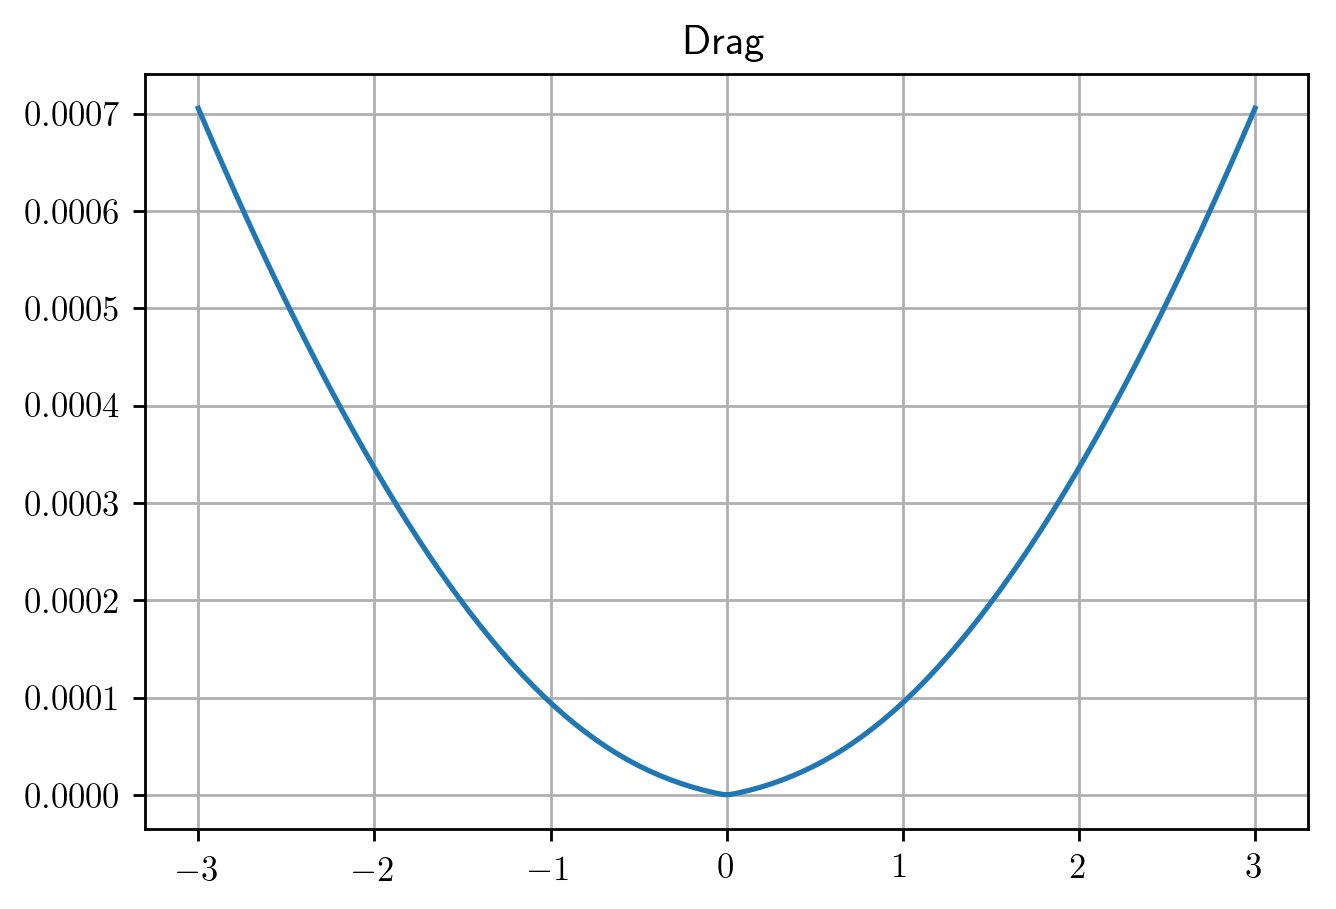

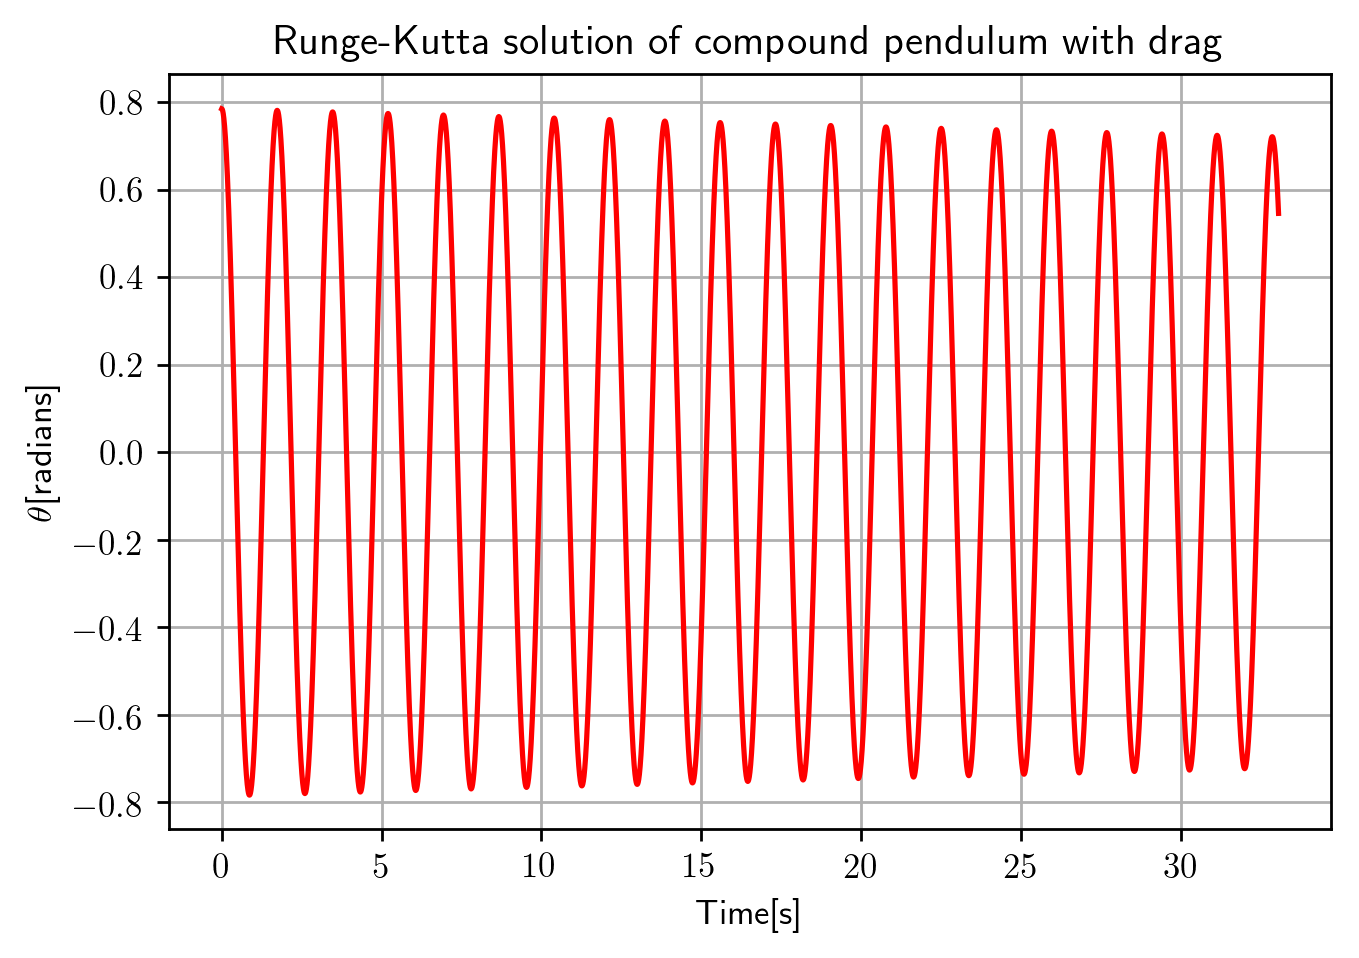

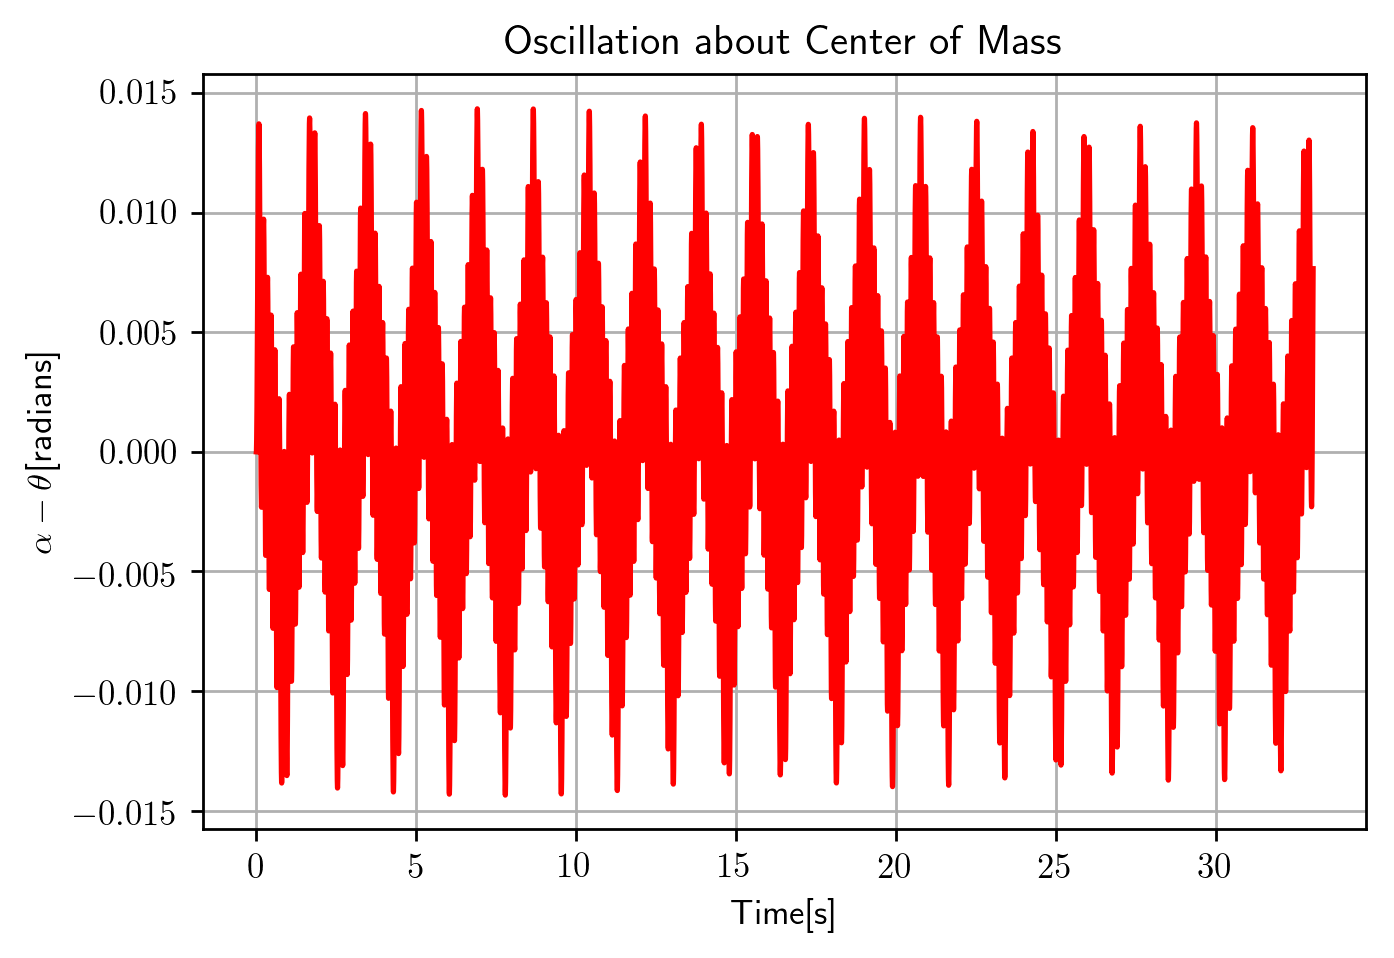

In [72]:
solution=solution2
plt.figure()
xom=np.linspace(-3,3,200)
plt.title('Drag')
plt.plot(xom,drag(l*xom)+wireTorqueCheb(l*xom))
plt.grid()
plt.figure()
plt.title('Runge-Kutta solution of compound pendulum with drag')
plt.plot(t, solution[:,0], 'r', label=r'\theta(t)')
plt.ylabel(r'$\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()  
plt.figure()
plt.title('Oscillation about Center of Mass')
plt.plot(t, solution[:,2]-solution[:,0], 'r', label=r'\alpha(t)-\theta(t)')
plt.ylabel(r'$\alpha-\theta$[radians]')
plt.xlabel('Time[s]')
plt.grid()  

